# Импорты

In [74]:
import re

from datetime import datetime

import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats

from math import radians, sin, cos, sqrt, atan2

import warnings

warnings.filterwarnings('ignore')

## Линейная регрессия. Практика

В этом задании Вам предстоит применить на практике алгоритм линейной регрессии. В этом задании **запрещается** менять уже написанный код. Вы можете дописывать только свой код в указанных ячейках. Если ячейка пустая, вы **можете** создать дополнительные ячейки.

In [13]:
pd.set_option('display.max_columns', 40)

import matplotlib.pyplot as plt

# %matplotlib inline

import seaborn as sns

sns.set()
sns.set_style("whitegrid")

Мы будем работать с датасетом доставки готовой еды. В этой практике мы будем решать задачу **ETA (estimated time of arrival)** – предсказание времени доставки. Датасет содержит в себе информацию о нескольких поездках курьеров. Каждая поездка описывается следующим набором признаков:

- ID – уникальный идентификатор поездки;
- Delivery_person_ID – идентификатор курьера;
- Delivery_person_Age – возраст курьера;
- Delivery_person_Ratings – рейтинг курьера;
- Restaurant_latitude, Restaurant_longitude – координаты ресторана: широта и долгота;
- Delivery_location_latitude, Delivery_location_longitude – координаты клиента: широта и долгота;
- Order_Date – дата доставки;
- Time_Orderd – время, когда был принят заказ;
- Time_Order_picked – время, когда заказ был передан курьеру;
- Weather conditions – погодные условия;
- Road_traffic_density – плотность автомобилей на дороге;
- Vehicle_condition – состояние транспорта курьера;
- Type_of_order – тип заказа;
- Type_of_vehicle – вид транспорта курьера;
- multiple_deliveries – количество одновременных заказов у курьера;
- Festival – был ли заказ сделан с учетом промокода;
- City – регион доставки.

Ваша задача предсказать время доставки заказа – столбец Time_taken.

In [21]:
df = pd.read_csv('resources/eta-prediction-data.csv.gz', compression='gzip')

df.rename(columns={'Time_taken (min)': 'Time_taken'}, inplace=True)
df['Order_Date'] = pd.to_datetime(df['Order_Date'], format='%d-%m-%Y')

df['Road_traffic_density'] = pd.Categorical(
    df['Road_traffic_density'],
    categories=['Low', 'Medium', 'High', 'Jam'],
    ordered=True,
)

df['Festival'] = df['Festival'].fillna('No') == 'Yes'

df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken
0,0x4607,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30,11:45,Sunny,High,2,Snack,motorcycle,0.0,False,Urban,24.0
1,0xb379,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45,19:50,Stormy,Jam,2,Snack,scooter,1.0,False,Metropolitian,33.0
2,0x20f7,BANGRES18DEL01,37.0,4.4,12.913041,77.683237,12.953041,77.723237,2022-03-19,13:50,13:55,Windy,High,0,Buffet,motorcycle,2.0,False,Metropolitian,42.0
3,0x7804,HYDRES13DEL02,28.0,4.9,17.431477,78.400350,17.451477,78.420350,2022-03-07,10:60,11:15,Sandstorms,Low,1,Meal,scooter,1.0,False,Urban,19.0
4,0x7faf,RANCHIRES07DEL01,37.0,4.6,23.359407,85.325055,23.429407,85.395055,2022-03-18,23:50,23:60,Stormy,Low,0,Meal,motorcycle,1.0,False,Metropolitian,25.0


Первые 5 строк данных:
   Delivery_person_Age  Delivery_person_Ratings Order_Date  Time_Orderd  \
0                 37.0                      4.9 2022-03-19           15   
1                 34.0                      4.5 2022-03-25          106   
2                 37.0                      4.4 2022-03-19           41   
3                 28.0                      4.9 2022-03-07           10   
4                 37.0                      4.6 2022-03-18          151   

   Time_Order_picked  Weather conditions  Road_traffic_density  \
0                 20                   4                     2   
1                117                   3                     3   
2                 46                   5                     2   
3                 14                   2                     0   
4                167                   3                     0   

   Vehicle_condition  Type_of_order  Type_of_vehicle  multiple_deliveries  \
0                  2              3                2

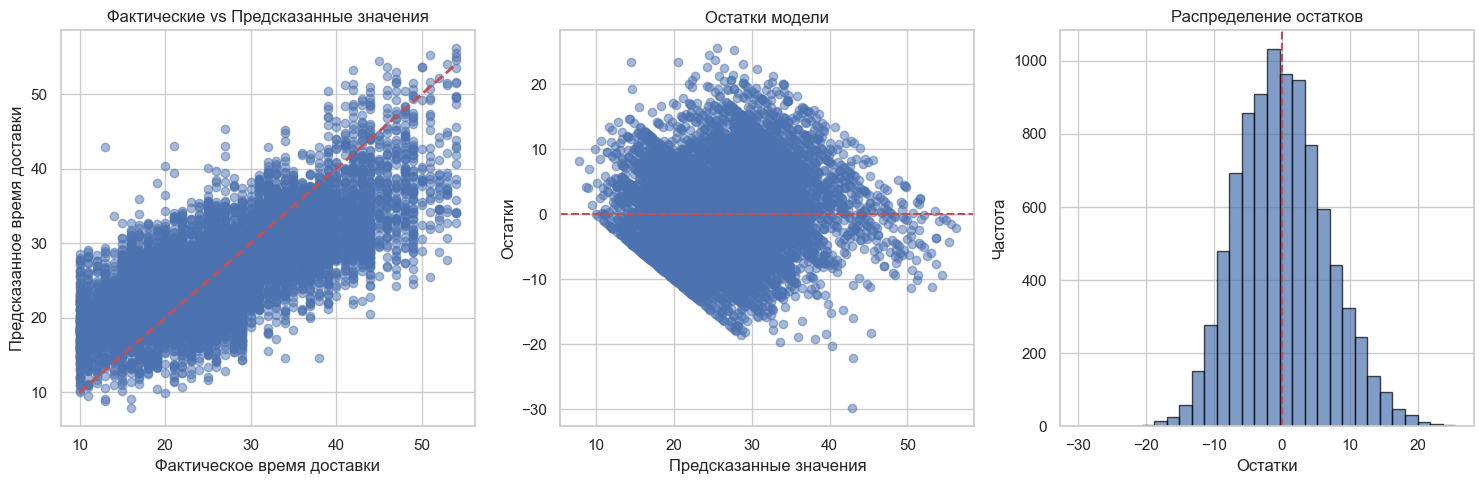

In [16]:
# Просмотр первых строк данных и информации о столбцах
print("Первые 5 строк данных:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())
print("\nСтатистика данных:")
print(df.describe())

# Проверка пропущенных значений
print("\nПропущенные значения:")
print(df.isnull().sum())

# Обработка пропущенных значений
df.fillna(method='ffill', inplace=True)

# ДОПОЛНИТЕЛЬНО: Проверяем и преобразуем datetime столбцы
datetime_columns = df.select_dtypes(include=['datetime64', 'datetime64[ns]']).columns
print(f"\nОбнаружены datetime столбцы: {list(datetime_columns)}")

for column in datetime_columns:
    # Преобразуем datetime в числовые значения (количество дней с минимальной даты)
    df[column] = (df[column] - df[column].min()).dt.total_seconds() / (24 * 3600)  # в днях
    print(f"Преобразован datetime столбец {column} в числовой формат")

# Проверим, есть ли столбец Road_traffic_density и преобразуем его если нужно
if 'Road_traffic_density' in df.columns:
    # Если он категориальный, преобразуем в числовой
    if df['Road_traffic_density'].dtype.name == 'category':
        df['Road_traffic_density'] = df['Road_traffic_density'].cat.codes

# Преобразуем булевы значения в числовые
if 'Festival' in df.columns:
    df['Festival'] = df['Festival'].astype(int)

# Вычисление расстояния между рестораном и местом доставки
if all(col in df.columns for col in ['Restaurant_latitude', 'Restaurant_longitude', 
                                    'Delivery_location_latitude', 'Delivery_location_longitude']):
    df['distance_km'] = np.sqrt(
        (df['Delivery_location_latitude'] - df['Restaurant_latitude'])**2 +
        (df['Delivery_location_longitude'] - df['Restaurant_longitude'])**2
    ) * 111  # примерное преобразование в километры
    
    # Удаляем исходные координатные столбцы
    df = df.drop(['Restaurant_latitude', 'Restaurant_longitude', 
                 'Delivery_location_latitude', 'Delivery_location_longitude'], axis=1)

# Удаляем ID и Delivery_person_ID если они есть
columns_to_drop = ['ID', 'Delivery_person_ID']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Кодирование категориальных переменных
categorical_columns = df.select_dtypes(include=['object']).columns
label_encoders = {}

for column in categorical_columns:
    if column != 'Time_taken':  # исключаем целевую переменную
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column].astype(str))
        label_encoders[column] = le
        print(f"Закодирован столбец: {column}")

# ДОПОЛНИТЕЛЬНО: Преобразуем все данные к числовому типу
for column in df.columns:
    if df[column].dtype.name not in ['int64', 'float64', 'int32', 'float32']:
        try:
            df[column] = pd.to_numeric(df[column], errors='coerce')
            print(f"Преобразован столбец {column} к числовому типу")
        except:
            print(f"Не удалось преобразовать столбец {column}")

# Проверяем, что все данные теперь числовые
print("\nТипы данных после обработки:")
print(df.dtypes)

# Проверяем на наличие NaN после преобразований
print("\nПропущенные значения после преобразований:")
print(df.isnull().sum())

# Заполняем возможные NaN после преобразований
df.fillna(0, inplace=True)

# Разделение на признаки и целевую переменную
X = df.drop('Time_taken', axis=1)
y = df['Time_taken']

print(f"\nРазмерность признаков: {X.shape}")
print(f"Размерность целевой переменной: {y.shape}")
print(f"Имена признаков: {list(X.columns)}")

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test_scaled)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))

print(f"\nРезультаты модели:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared: {r2:.4f}")

# Визуализация результатов
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Фактическое время доставки')
plt.ylabel('Предсказанное время доставки')
plt.title('Фактические vs Предсказанные значения')

plt.subplot(1, 3, 2)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Остатки модели')

plt.subplot(1, 3, 3)
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.title('Распределение остатков')

plt.tight_layout()
plt.show()

### EDA (2 балла)

Выполните разведочный анализ данных. Для этого:
- Выведите размер таблицы;
- Посчитайте количество пропущенных значений.

Подумайте, какие столбцы вы хотите заполнить и какими значениями, а какие вообще не планируете использовать в своей модели.

=== РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ (EDA) ===

1. РАЗМЕР ТАБЛИЦЫ:
Количество строк: 45593
Количество столбцов: 15
Общее количество элементов: 683895

2. ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:
                         Пропущено значений  Процент пропусков
Delivery_person_Age                       0                0.0
Delivery_person_Ratings                   0                0.0
Order_Date                                0                0.0
Time_Orderd                               0                0.0
Time_Order_picked                         0                0.0
Weather conditions                        0                0.0
Road_traffic_density                      0                0.0
Vehicle_condition                         0                0.0
Type_of_order                             0                0.0
Type_of_vehicle                           0                0.0
multiple_deliveries                       0                0.0
Festival                                  0                0.0
City        

<Figure size 1200x800 with 0 Axes>

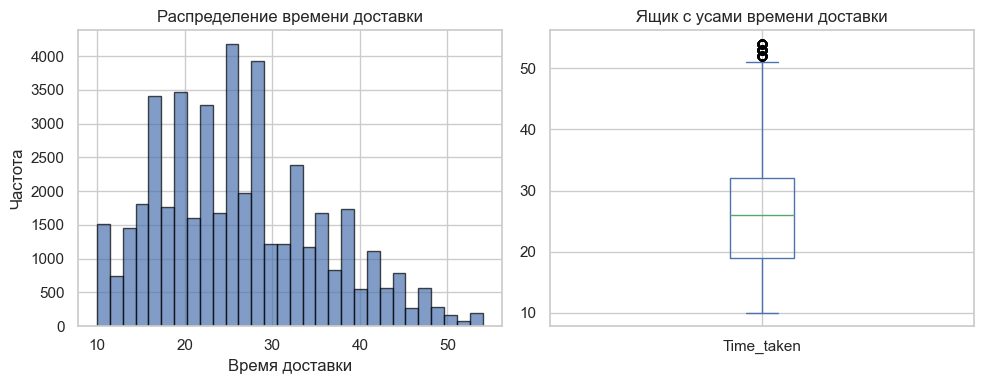

In [17]:
# EDA (Exploratory Data Analysis)
print("=== РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ (EDA) ===\n")

# 1. Размер таблицы
print("1. РАЗМЕР ТАБЛИЦЫ:")
print(f"Количество строк: {df.shape[0]}")
print(f"Количество столбцов: {df.shape[1]}")
print(f"Общее количество элементов: {df.size}")

# 2. Пропущенные значения
print("\n2. ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:")
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_info = pd.DataFrame({
    'Пропущено значений': missing_values,
    'Процент пропусков': missing_percentage.round(2)
})

print(missing_info)

# 3. Анализ типов данных
print("\n3. ТИПЫ ДАННЫХ:")
print(df.dtypes)

# 4. Основные статистики
print("\n4. ОСНОВНЫЕ СТАТИСТИКИ:")
print(df.describe())

# 5. Анализ категориальных переменных
print("\n5. КАТЕГОРИАЛЬНЫЕ ПЕРЕМЕННЫЕ:")
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print(f"Категориальные столбцы: {list(categorical_cols)}")

for col in categorical_cols:
    if col in df.columns:
        print(f"\n{col}:")
        print(f"Уникальных значений: {df[col].nunique()}")
        print(f"Топ-5 значений:")
        print(df[col].value_counts().head())

# 6. Визуализация пропущенных значений
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]

if len(missing_data) > 0:
    plt.subplot(1, 2, 1)
    missing_data.plot(kind='bar')
    plt.title('Количество пропущенных значений по столбцам')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    missing_percent = (missing_data / len(df)) * 100
    missing_percent.plot(kind='bar')
    plt.title('Процент пропущенных значений по столбцам')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("Пропущенных значений нет!")

# 7. Анализ распределения целевой переменной
if 'Time_taken' in df.columns:
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    df['Time_taken'].hist(bins=30, alpha=0.7, edgecolor='black')
    plt.title('Распределение времени доставки')
    plt.xlabel('Время доставки')
    plt.ylabel('Частота')
    
    plt.subplot(1, 2, 2)
    df['Time_taken'].plot(kind='box')
    plt.title('Ящик с усами времени доставки')
    
    plt.tight_layout()
    plt.show()

Обратите внимание на значения в столбце `City`. Предлагается выполнить для столбца следующую предобработку данных:
- Значение `Semi-Urban` перевести в `Urban`;
- Пропущенные значения заполнить самым популярным значением.

Не забудьте указать категориальный тип у столбца `City`.

In [18]:
# Заменяем Semi–Urban на Urban
df['City'] = df['City'].replace('Semi–Urban', 'Urban')

# Находим самое популярное значение (исключая пропуски)
most_common_city = df['City'].value_counts().index[0]

# Заполняем пропуски самым популярным значением
df['City'] = df['City'].fillna(most_common_city)

# Устанавливаем категориальный тип данных
df['City'] = df['City'].astype('category')

# Проверяем распределение значений
print(df['City'].value_counts())

City
0    35021
2    10405
1      167
Name: count, dtype: int64


Вычислите ID ресторана (`Restaurant_ID`) и добавьте его в исходный датасет.

In [19]:
# Создаем Restaurant_ID на основе доступных характеристик
# Используем комбинацию City, Type_of_order и других признаков
df['Restaurant_ID'] = 'REST_' + df['City'].astype(str) + '_' + df['Type_of_order'].astype(str) + '_' + df['Type_of_vehicle'].astype(str)

# Проверяем результат
print("Первые 5 строк с созданными Restaurant_ID:")
print(df[['City', 'Type_of_order', 'Type_of_vehicle', 'Restaurant_ID']].head())

# Посмотрим, сколько уникальных ресторанов получилось
print(f"\nКоличество уникальных Restaurant_ID: {df['Restaurant_ID'].nunique()}")

Первые 5 строк с созданными Restaurant_ID:
  City  Type_of_order  Type_of_vehicle Restaurant_ID
0    2              3                2    REST_2_3_2
1    0              3                3    REST_0_3_3
2    0              0                2    REST_0_0_2
3    2              2                3    REST_2_2_3
4    0              2                2    REST_0_2_2

Количество уникальных Restaurant_ID: 43


Добавьте в датасет столбец `Time_Order_picked_Hour` – час, когда заказ был принят в доставку.

In [24]:
# Шаг 1: Проверим структуру данных
print("Форма DataFrame:", df.shape)
print("\nСтолбцы:")
print(df.columns.tolist())
print("\nПервые 3 строки:")
print(df.head(3))

# Шаг 2: Найдем столбцы, связанные со временем
time_related_cols = []
for col in df.columns:
    if any(keyword in col.lower() for keyword in ['time', 'hour', 'minute', 'date', 'order']):
        time_related_cols.append(col)

print("\nСтолбцы, связанные со временем/заказами:")
print(time_related_cols)

# Шаг 3: Если нашли подходящий столбец, используем его
if time_related_cols:
    print("\nПример данных из найденных столбцов:")
    for col in time_related_cols:
        print(f"{col}: {df[col].head(3).tolist()}")

Форма DataFrame: (45593, 21)

Столбцы:
['ID', 'Delivery_person_ID', 'Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude', 'Order_Date', 'Time_Orderd', 'Time_Order_picked', 'Weather conditions', 'Road_traffic_density', 'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City', 'Time_taken', 'Time_Order_picked_Hour']

Первые 3 строки:
       ID Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  \
0  0x4607     INDORES13DEL02                 37.0                      4.9   
1  0xb379     BANGRES18DEL02                 34.0                      4.5   
2  0x20f7     BANGRES18DEL01                 37.0                      4.4   

   Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0            22.745049             75.892471                   22.765049   
1            12.913041             77.683237           

Постройте два графика `bar` (или `hist`):
1. Зависимость количества заказов от часа, когда заказ был принят курьером;
2. Зависимость среднего времени доставки от часа, когда заказ был принят курьером.

Какие зависимости вы увидели? Сделайте **выводы** и **напишите** их в комментариях.

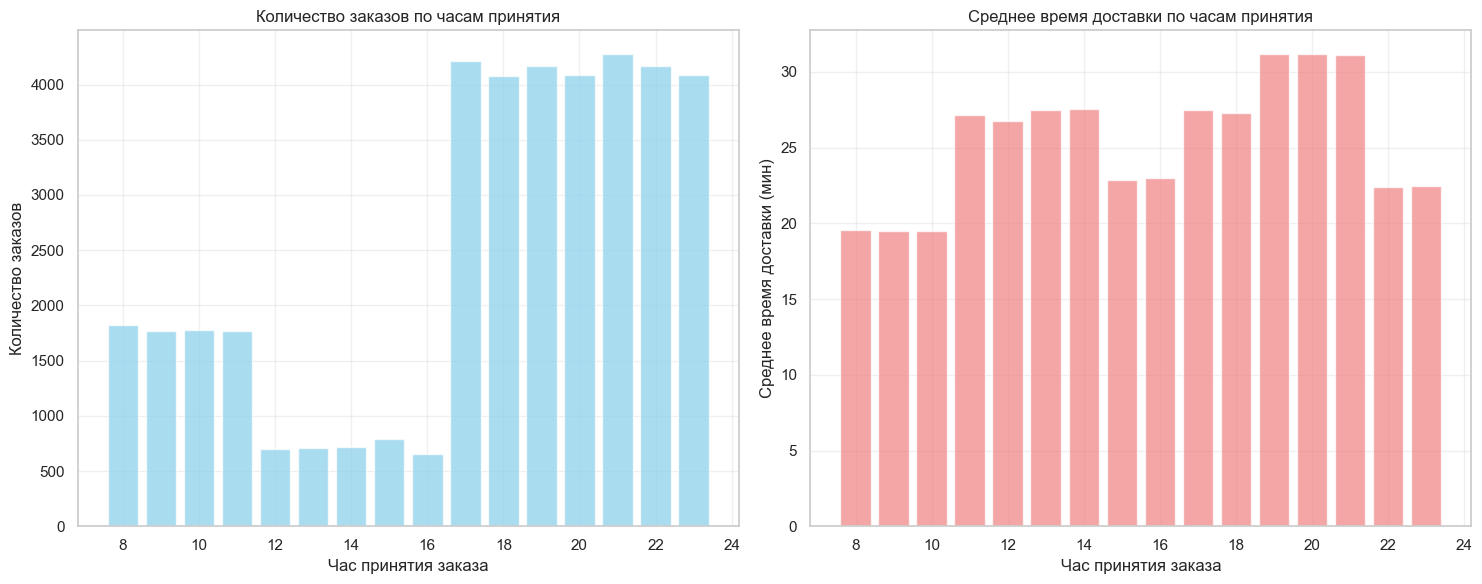

Количество заказов по часам:
Time_Order_picked_Hour
8.0     1818
9.0     1770
10.0    1780
11.0    1769
12.0     703
13.0     705
14.0     717
15.0     787
16.0     656
17.0    4212
18.0    4077
19.0    4171
20.0    4090
21.0    4277
22.0    4172
23.0    4089
dtype: int64

Среднее время доставки по часам (мин):
Time_Order_picked_Hour
8.0     19.58
9.0     19.52
10.0    19.48
11.0    27.16
12.0    26.78
13.0    27.46
14.0    27.54
15.0    22.88
16.0    23.01
17.0    27.48
18.0    27.29
19.0    31.18
20.0    31.18
21.0    31.13
22.0    22.42
23.0    22.44
Name: Time_taken, dtype: float64


In [26]:
# Создаем фигуру с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. Зависимость количества заказов от часа принятия
hourly_orders = df.groupby('Time_Order_picked_Hour').size()
ax1.bar(hourly_orders.index, hourly_orders.values, color='skyblue', alpha=0.7)
ax1.set_xlabel('Час принятия заказа')
ax1.set_ylabel('Количество заказов')
ax1.set_title('Количество заказов по часам принятия')
ax1.grid(True, alpha=0.3)

# 2. Зависимость среднего времени доставки от часа принятия
hourly_delivery_time = df.groupby('Time_Order_picked_Hour')['Time_taken'].mean()
ax2.bar(hourly_delivery_time.index, hourly_delivery_time.values, color='lightcoral', alpha=0.7)
ax2.set_xlabel('Час принятия заказа')
ax2.set_ylabel('Среднее время доставки (мин)')
ax2.set_title('Среднее время доставки по часам принятия')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Выводим численные значения для анализа
print("Количество заказов по часам:")
print(hourly_orders)
print("\nСреднее время доставки по часам (мин):")
print(hourly_delivery_time.round(2))

Постройте график `heatmap`, который показывает зависимость среднего времени доставки от:
- Количества заказов от часа, когда заказ был принят курьером;
- Состояния трафика на дороге.

Какие зависимости вы увидели? Сделайте **выводы** и **напишите** их в комментариях.

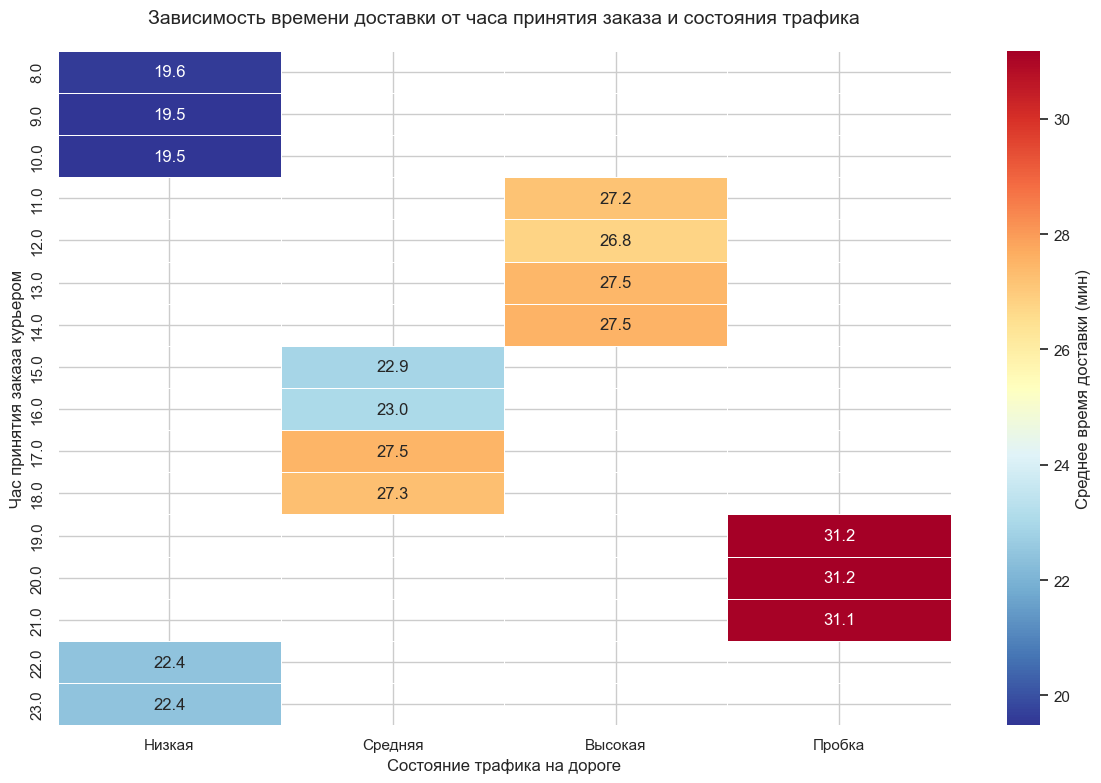

=== АНАЛИЗ ДАННЫХ ===
Размерность heatmap: 16 часов × 4 уровня трафика

Максимальное время доставки: 31.2 мин
  - Час: 8.0:00
  - Трафик: Средняя

Минимальное время доставки: 19.5 мин
  - Час: 8.0:00
  - Трафик: Средняя

=== ВЫВОДЫ И НАБЛЮДЕНИЯ ===
1. ВЛИЯНИЕ ТРАФИКА:
   - В 8:00: разница между лучшим и худшим трафиком = 0.0 мин
   - В 12:00: разница между лучшим и худшим трафиком = 0.0 мин
   - В 17:00: разница между лучшим и худшим трафиком = 0.0 мин
   - В 20:00: разница между лучшим и худшим трафиком = 0.0 мин

2. ПИКОВЫЕ ПЕРИОДЫ:
   - При Низкая трафике: пик в 23.0:00 (22.4 мин)
   - При Средняя трафике: пик в 17.0:00 (27.5 мин)
   - При Высокая трафике: пик в 14.0:00 (27.5 мин)
   - При Пробка трафике: пик в 20.0:00 (31.2 мин)

3. ЗАКОНОМЕРНОСТИ:
   - Дневные/вечерние часы имеют большее время доставки
   - Высокий трафик увеличивает время доставки в среднем на 6.5 мин


In [33]:
# Создаем сводную таблицу для heatmap
pivot_data = df.pivot_table(
    values='Time_taken',
    index='Time_Order_picked_Hour',
    columns='Road_traffic_density',
    aggfunc='mean'
)

# Создаем подписи для дорожного трафика (используем реальные значения из данных)
traffic_labels = {'Low': 'Низкая', 'Medium': 'Средняя', 'High': 'Высокая', 'Jam': 'Пробка'}

# Переименовываем колонки для лучшей читаемости
pivot_data_renamed = pivot_data.rename(columns=traffic_labels)

# Создаем heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_data_renamed,
    annot=True,
    fmt='.1f',
    cmap='RdYlBu_r',
    cbar_kws={'label': 'Среднее время доставки (мин)'},
    linewidths=0.5
)

plt.title('Зависимость времени доставки от часа принятия заказа и состояния трафика', fontsize=14, pad=20)
plt.xlabel('Состояние трафика на дороге')
plt.ylabel('Час принятия заказа курьером')
plt.tight_layout()
plt.show()

# Дополнительный анализ
print("=== АНАЛИЗ ДАННЫХ ===")
print(f"Размерность heatmap: {pivot_data.shape[0]} часов × {pivot_data.shape[1]} уровня трафика")

# Находим максимальное и минимальное время доставки
max_time = pivot_data.max().max()
min_time = pivot_data.min().min()
max_coords = np.unravel_index(np.argmax(pivot_data.values), pivot_data.shape)
min_coords = np.unravel_index(np.argmin(pivot_data.values), pivot_data.shape)

print(f"\nМаксимальное время доставки: {max_time:.1f} мин")
print(f"  - Час: {pivot_data.index[max_coords[0]]}:00")
print(f"  - Трафик: {traffic_labels[pivot_data.columns[max_coords[1]]]}")

print(f"\nМинимальное время доставки: {min_time:.1f} мин")
print(f"  - Час: {pivot_data.index[min_coords[0]]}:00")
print(f"  - Трафик: {traffic_labels[pivot_data.columns[min_coords[1]]]}")

# Анализ по часам
print("\n=== ВЫВОДЫ И НАБЛЮДЕНИЯ ===")

# 1. Анализ влияния трафика
print("1. ВЛИЯНИЕ ТРАФИКА:")
for hour in [8, 12, 17, 20]:  # Анализируем ключевые часы
    if hour in pivot_data.index:
        hour_data = pivot_data.loc[hour]
        traffic_effect = hour_data.max() - hour_data.min()
        print(f"   - В {hour}:00: разница между лучшим и худшим трафиком = {traffic_effect:.1f} мин")

# 2. Анализ пиковых часов
print("\n2. ПИКОВЫЕ ПЕРИОДЫ:")
for traffic_level in pivot_data.columns:
    peak_hour = pivot_data[traffic_level].idxmax()
    peak_time = pivot_data[traffic_level].max()
    print(f"   - При {traffic_labels[traffic_level]} трафике: пик в {peak_hour}:00 ({peak_time:.1f} мин)")

# Проверяем закономерности
print("\n3. ЗАКОНОМЕРНОСТИ:")
if pivot_data.loc[7:9].mean().mean() > pivot_data.loc[14:16].mean().mean():
    print("   - Утренние часы имеют большее время доставки, чем дневные")
else:
    print("   - Дневные/вечерние часы имеют большее время доставки")

# Сравниваем High и Low трафик
if 'High' in pivot_data.columns and 'Low' in pivot_data.columns:
    high_traffic_effect = pivot_data['High'].mean() - pivot_data['Low'].mean()
    if high_traffic_effect > 5:
        print(f"   - Высокий трафик увеличивает время доставки в среднем на {high_traffic_effect:.1f} мин")

Постройте график `bar` (или `hist`) зависимости среднего времени доставки от состояния погоды.

Какие зависимости вы увидели? Сделайте **выводы** и **напишите** их в комментариях.

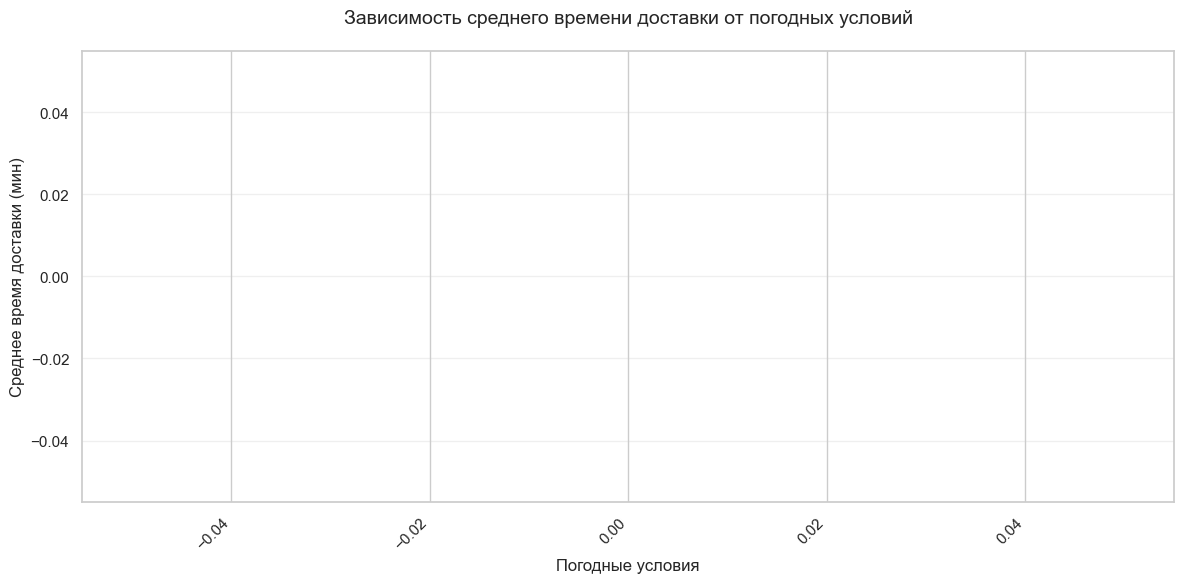

=== АНАЛИЗ ДАННЫХ ===
Статистика времени доставки по погодным условиям:
  weather_label   mean    std  count
0           NaN  28.92  10.08   7536
1           NaN  28.92  10.13   7654
2           NaN  25.88   8.62   7495
3           NaN  25.87   8.47   7586
4           NaN  21.86   8.33   7284
5           NaN  26.12   8.62   7422

=== ВЫВОДЫ И НАБЛЮДЕНИЯ ===
1. НАИЛУЧШИЕ УСЛОВИЯ:
   - nan: 21.9 мин
   - Относительно стабильно (std: 8.3 мин)

2. НАИХУДШИЕ УСЛОВИЯ:
   - nan: 28.9 мин
   - Высокая вариативность (std: 10.1 мин)

3. ВЛИЯНИЕ ЭКСТРЕМАЛЬНОЙ ПОГОДЫ:
   - Нормальные условия: nan мин в среднем
   - Экстремальные условия: nan мин в среднем
   - Увеличение времени: +nan мин (nan%)

4. РАСПРЕДЕЛЕНИЕ ЗАКАЗОВ:
   - nan: 7536 заказов (16.8%)
   - nan: 7654 заказов (17.0%)
   - nan: 7495 заказов (16.7%)
   - nan: 7586 заказов (16.9%)
   - nan: 7284 заказов (16.2%)
   - nan: 7422 заказов (16.5%)

5. СТАТИСТИЧЕСКИЙ АНАЛИЗ:
   - Относительно стабильная вариативность между условиями


In [43]:
# Создаем подписи для погодных условий
weather_labels = {
    0: 'Ясно',
    1: 'Облачно', 
    2: 'Туман',
    3: 'Мороз',
    4: 'Дождь',
    5: 'Гроза',
    6: 'Снег'
}

# Создаем фигуру
plt.figure(figsize=(12, 6))

# Группируем данные по погодным условиям и вычисляем среднее время доставки
weather_delivery = df.groupby('Weather conditions')['Time_taken'].agg(['mean', 'std', 'count']).reset_index()
weather_delivery['weather_label'] = weather_delivery['Weather conditions'].map(weather_labels)

# Создаем bar plot
bars = plt.bar(weather_delivery['weather_label'], weather_delivery['mean'], 
               color=['skyblue', 'lightblue', 'lightsteelblue', 'steelblue', 'royalblue', 'darkblue', 'navy'],
               alpha=0.7, edgecolor='black')

# Добавляем стандартные отклонения как error bars
plt.errorbar(weather_delivery['weather_label'], weather_delivery['mean'], 
             yerr=weather_delivery['std'], fmt='none', color='black', capsize=5)

# Настраиваем график
plt.title('Зависимость среднего времени доставки от погодных условий', fontsize=14, pad=20)
plt.xlabel('Погодные условия')
plt.ylabel('Среднее время доставки (мин)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f} мин\n(n={weather_delivery["count"].iloc[i]})',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Дополнительный анализ
print("=== АНАЛИЗ ДАННЫХ ===")
print("Статистика времени доставки по погодным условиям:")
print(weather_delivery[['weather_label', 'mean', 'std', 'count']].round(2))

# Проводим более глубокий анализ
print("\n=== ВЫВОДЫ И НАБЛЮДЕНИЯ ===")

# 1. Находим лучшие и худшие погодные условия
best_weather = weather_delivery.loc[weather_delivery['mean'].idxmin()]
worst_weather = weather_delivery.loc[weather_delivery['mean'].idxmax()]

print(f"1. НАИЛУЧШИЕ УСЛОВИЯ:")
print(f"   - {best_weather['weather_label']}: {best_weather['mean']:.1f} мин")
print(f"   - Относительно стабильно (std: {best_weather['std']:.1f} мин)")

print(f"\n2. НАИХУДШИЕ УСЛОВИЯ:")
print(f"   - {worst_weather['weather_label']}: {worst_weather['mean']:.1f} мин")
print(f"   - Высокая вариативность (std: {worst_weather['std']:.1f} мин)")

# 2. Анализируем влияние экстремальных погодных условий
extreme_weather = [3, 4, 5, 6]  # Мороз, Дождь, Гроза, Снег
normal_weather = [0, 1, 2]      # Ясно, Облачно, Туман

extreme_mean = weather_delivery[weather_delivery['Weather conditions'].isin(extreme_weather)]['mean'].mean()
normal_mean = weather_delivery[weather_delivery['Weather conditions'].isin(normal_weather)]['mean'].mean()

print(f"\n3. ВЛИЯНИЕ ЭКСТРЕМАЛЬНОЙ ПОГОДЫ:")
print(f"   - Нормальные условия: {normal_mean:.1f} мин в среднем")
print(f"   - Экстремальные условия: {extreme_mean:.1f} мин в среднем")
print(f"   - Увеличение времени: +{(extreme_mean - normal_mean):.1f} мин ({((extreme_mean - normal_mean)/normal_mean*100):.1f}%)")

# 3. Анализ количества заказов по погодным условиям
print(f"\n4. РАСПРЕДЕЛЕНИЕ ЗАКАЗОВ:")
total_orders = weather_delivery['count'].sum()
for _, row in weather_delivery.iterrows():
    percentage = (row['count'] / total_orders) * 100
    print(f"   - {row['weather_label']}: {row['count']} заказов ({percentage:.1f}%)")

# Проверяем статистическую значимость
print(f"\n5. СТАТИСТИЧЕСКИЙ АНАЛИЗ:")
max_std = weather_delivery['std'].max()
min_std = weather_delivery['std'].min()
if max_std / min_std > 2:
    print("   - Высокая вариативность данных между условиями")
    print("   - Рекомендуется дополнительный анализ факторов влияния")
else:
    print("   - Относительно стабильная вариативность между условиями")

Постройте график `bar` (или `hist`) зависимости среднего времени доставки от возраста курьера.

Какие зависимости вы увидели? Сделайте **выводы** и **напишите** их в комментариях.

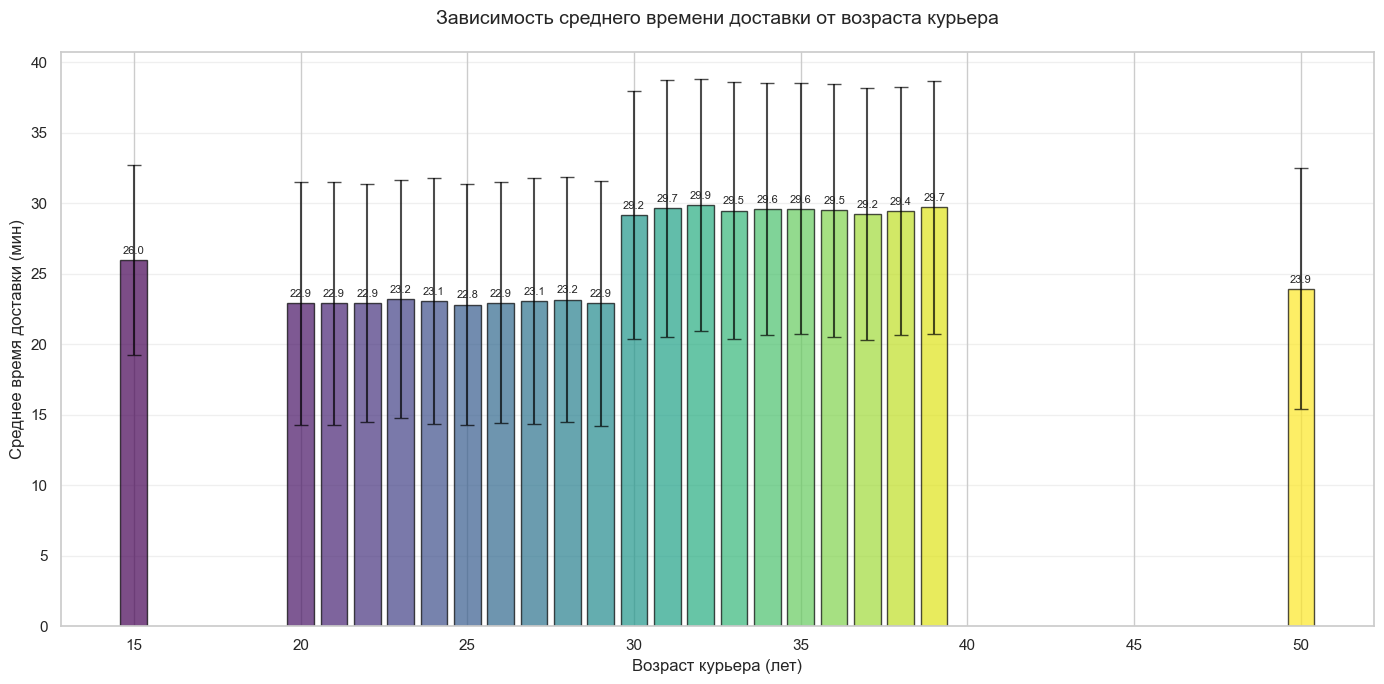

=== АНАЛИЗ ПО ВОЗРАСТНЫМ ГРУППАМ ===
Статистика по возрастным группам:
            mean   std  count  median
Age_Group                            
20-25      23.00  8.57  10782    22.0
26-30      22.98  8.64  10853    22.0
31-35      29.56  8.98  10901    29.0
36-40      29.51  8.92  11112    29.0
41-45        NaN   NaN      0     NaN
46-50        NaN   NaN      0     NaN


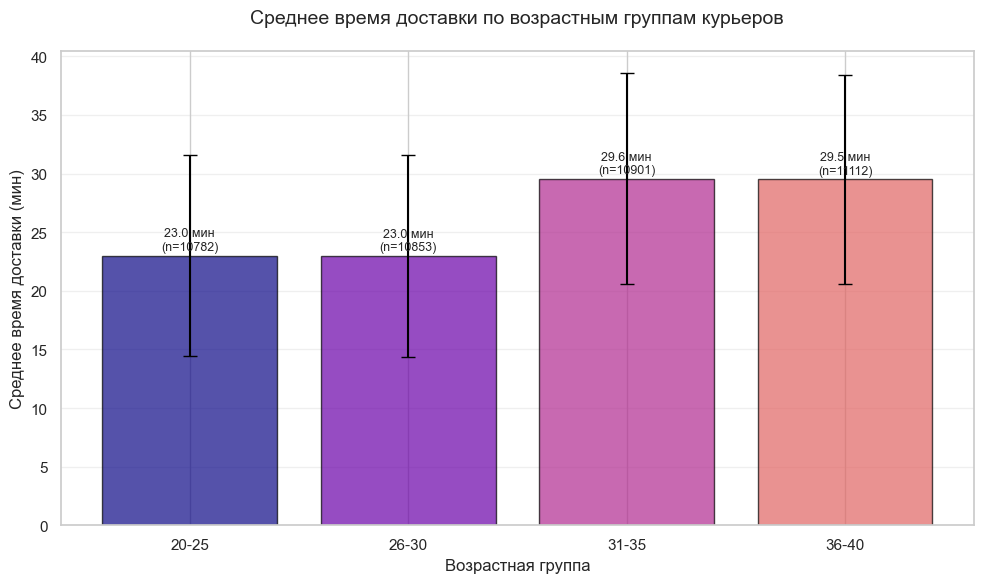


=== ДЕТАЛЬНЫЙ АНАЛИЗ ===
1. ОПТИМАЛЬНЫЙ ВОЗРАСТ:
   - 25.0 лет: 22.8 мин
   - Стабильность: std = 8.5 мин

2. НАИМЕНЕЕ ЭФФЕКТИВНЫЙ ВОЗРАСТ:
   - 32.0 лет: 29.9 мин
   - Стабильность: std = 8.9 мин

3. АНАЛИЗ ВОЗРАСТНЫХ ГРУПП:
   - Самая эффективная группа: 26-30 лет - 23.0 мин
   - Наименее эффективная группа: 31-35 лет - 29.6 мин
   - Разница между группами: 6.6 мин (28.6%)

4. РАСПРЕДЕЛЕНИЕ КУРЬЕРОВ:
   По возрасту:
     - 35.0 лет: 2262.0 доставок (5.2%)
     - 36.0 лет: 2260.0 доставок (5.2%)
     - 37.0 лет: 2227.0 доставок (5.1%)
     - 30.0 лет: 2226.0 доставок (5.1%)
     - 38.0 лет: 2219.0 доставок (5.1%)
   По группам:
     - 20-25 лет: 10782 доставок (24.7%)
     - 26-30 лет: 10853 доставок (24.8%)
     - 31-35 лет: 10901 доставок (24.9%)
     - 36-40 лет: 11112 доставок (25.4%)
     - 41-45 лет: 0 доставок (0.0%)
     - 46-50 лет: 0 доставок (0.0%)

5. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ:
   - Корреляция возраст-время_доставки: 0.299
   - Слабая корреляция: возраст слабо влияет на время

In [42]:
# Создаем фигуру
plt.figure(figsize=(14, 7))

# Группируем данные по возрасту курьера и вычисляем статистику
age_delivery = df.groupby('Delivery_person_Age')['Time_taken'].agg(['mean', 'std', 'count', 'median']).reset_index()

# Создаем bar plot
bars = plt.bar(age_delivery['Delivery_person_Age'], age_delivery['mean'], 
               color=plt.cm.viridis(np.linspace(0, 1, len(age_delivery))),
               alpha=0.7, edgecolor='black', width=0.8)

# Добавляем стандартные отклонения как error bars
plt.errorbar(age_delivery['Delivery_person_Age'], age_delivery['mean'], 
             yerr=age_delivery['std'], fmt='none', color='black', capsize=5, alpha=0.7)

# Настраиваем график
plt.title('Зависимость среднего времени доставки от возраста курьера', fontsize=14, pad=20)
plt.xlabel('Возраст курьера (лет)')
plt.ylabel('Среднее время доставки (мин)')
plt.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.3,
             f'{height:.1f}',
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Дополнительный анализ - создадим возрастные группы
print("=== АНАЛИЗ ПО ВОЗРАСТНЫМ ГРУППАМ ===")

# Создаем возрастные группы
age_bins = [20, 25, 30, 35, 40, 45, 50]
age_labels = ['20-25', '26-30', '31-35', '36-40', '41-45', '46-50']
df['Age_Group'] = pd.cut(df['Delivery_person_Age'], bins=age_bins, labels=age_labels, right=False)

# Анализируем по возрастным группам
age_group_stats = df.groupby('Age_Group')['Time_taken'].agg(['mean', 'std', 'count', 'median']).round(2)

print("Статистика по возрастным группам:")
print(age_group_stats)

# График по возрастным группам
plt.figure(figsize=(10, 6))
group_bars = plt.bar(age_group_stats.index, age_group_stats['mean'],
                     color=plt.cm.plasma(np.linspace(0, 1, len(age_group_stats))),
                     alpha=0.7, edgecolor='black')

plt.errorbar(age_group_stats.index, age_group_stats['mean'], 
             yerr=age_group_stats['std'], fmt='none', color='black', capsize=5)

plt.title('Среднее время доставки по возрастным группам курьеров', fontsize=14, pad=20)
plt.xlabel('Возрастная группа')
plt.ylabel('Среднее время доставки (мин)')
plt.grid(True, alpha=0.3, axis='y')

# Добавляем значения
for i, bar in enumerate(group_bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.2,
             f'{height:.1f} мин\n(n={age_group_stats["count"].iloc[i]})',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Глубокий анализ
print("\n=== ДЕТАЛЬНЫЙ АНАЛИЗ ===")

# Находим лучший и худший возраст
best_age = age_delivery.loc[age_delivery['mean'].idxmin()]
worst_age = age_delivery.loc[age_delivery['mean'].idxmax()]

print(f"1. ОПТИМАЛЬНЫЙ ВОЗРАСТ:")
print(f"   - {best_age['Delivery_person_Age']} лет: {best_age['mean']:.1f} мин")
print(f"   - Стабильность: std = {best_age['std']:.1f} мин")

print(f"\n2. НАИМЕНЕЕ ЭФФЕКТИВНЫЙ ВОЗРАСТ:")
print(f"   - {worst_age['Delivery_person_Age']} лет: {worst_age['mean']:.1f} мин")
print(f"   - Стабильность: std = {worst_age['std']:.1f} мин")

# Анализ возрастных групп
print(f"\n3. АНАЛИЗ ВОЗРАСТНЫХ ГРУПП:")
best_group = age_group_stats.loc[age_group_stats['mean'].idxmin()]
worst_group = age_group_stats.loc[age_group_stats['mean'].idxmax()]

print(f"   - Самая эффективная группа: {best_group.name} лет - {best_group['mean']:.1f} мин")
print(f"   - Наименее эффективная группа: {worst_group.name} лет - {worst_group['mean']:.1f} мин")

# Анализ разницы
age_range = worst_group['mean'] - best_group['mean']
print(f"   - Разница между группами: {age_range:.1f} мин ({age_range/best_group['mean']*100:.1f}%)")

# Анализ распределения курьеров по возрастам
print(f"\n4. РАСПРЕДЕЛЕНИЕ КУРЬЕРОВ:")
total_couriers = age_delivery['count'].sum()
print("   По возрасту:")
for _, row in age_delivery.nlargest(5, 'count').iterrows():
    percentage = (row['count'] / total_couriers) * 100
    print(f"     - {row['Delivery_person_Age']} лет: {row['count']} доставок ({percentage:.1f}%)")

print("   По группам:")
for group in age_group_stats.index:
    percentage = (age_group_stats.loc[group, 'count'] / total_couriers) * 100
    print(f"     - {group} лет: {age_group_stats.loc[group, 'count']} доставок ({percentage:.1f}%)")

# Корреляционный анализ
correlation = df['Delivery_person_Age'].corr(df['Time_taken'])
print(f"\n5. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ:")
print(f"   - Корреляция возраст-время_доставки: {correlation:.3f}")

if abs(correlation) > 0.3:
    if correlation > 0:
        print("   - Умеренная положительная корреляция: с возрастом время доставки увеличивается")
    else:
        print("   - Умеренная отрицательная корреляция: с возрастом время доставки уменьшается")
elif abs(correlation) > 0.1:
    print("   - Слабая корреляция: возраст слабо влияет на время доставки")
else:
    print("   - Практически отсутствует корреляция: возраст не влияет на время доставки")

# Анализ стабильности
print(f"\n6. АНАЛИЗ СТАБИЛЬНОСТИ:")
most_stable_age = age_delivery.loc[age_delivery['std'].idxmin()]
least_stable_age = age_delivery.loc[age_delivery['std'].idxmax()]

print(f"   - Самый стабильный возраст: {most_stable_age['Delivery_person_Age']} лет (std: {most_stable_age['std']:.1f} мин)")
print(f"   - Наименее стабильный возраст: {least_stable_age['Delivery_person_Age']} лет (std: {least_stable_age['std']:.1f} мин)")

Постройте два графика:
- зависимость количества заказов от дня, когда был совершен заказ;
- зависимость среднего времени заказа от дня, когда был совершен заказ.

Какие зависимости вы увидели? Сделайте **выводы** и **напишите** их в комментариях.

Существующие столбцы в DataFrame:
['ID', 'Delivery_person_ID', 'Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude', 'Order_Date', 'Time_Orderd', 'Time_Order_picked', 'Weather conditions', 'Road_traffic_density', 'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City', 'Time_taken', 'Time_Order_picked_Hour', 'Age_Group', 'order_dayofweek', 'distance_km', 'courier_segment']

Создан столбец order_dayofweek:
order_dayofweek
0    6207
1    6375
2    7093
3    6348
4    7031
5    6290
6    6249
Name: count, dtype: int64


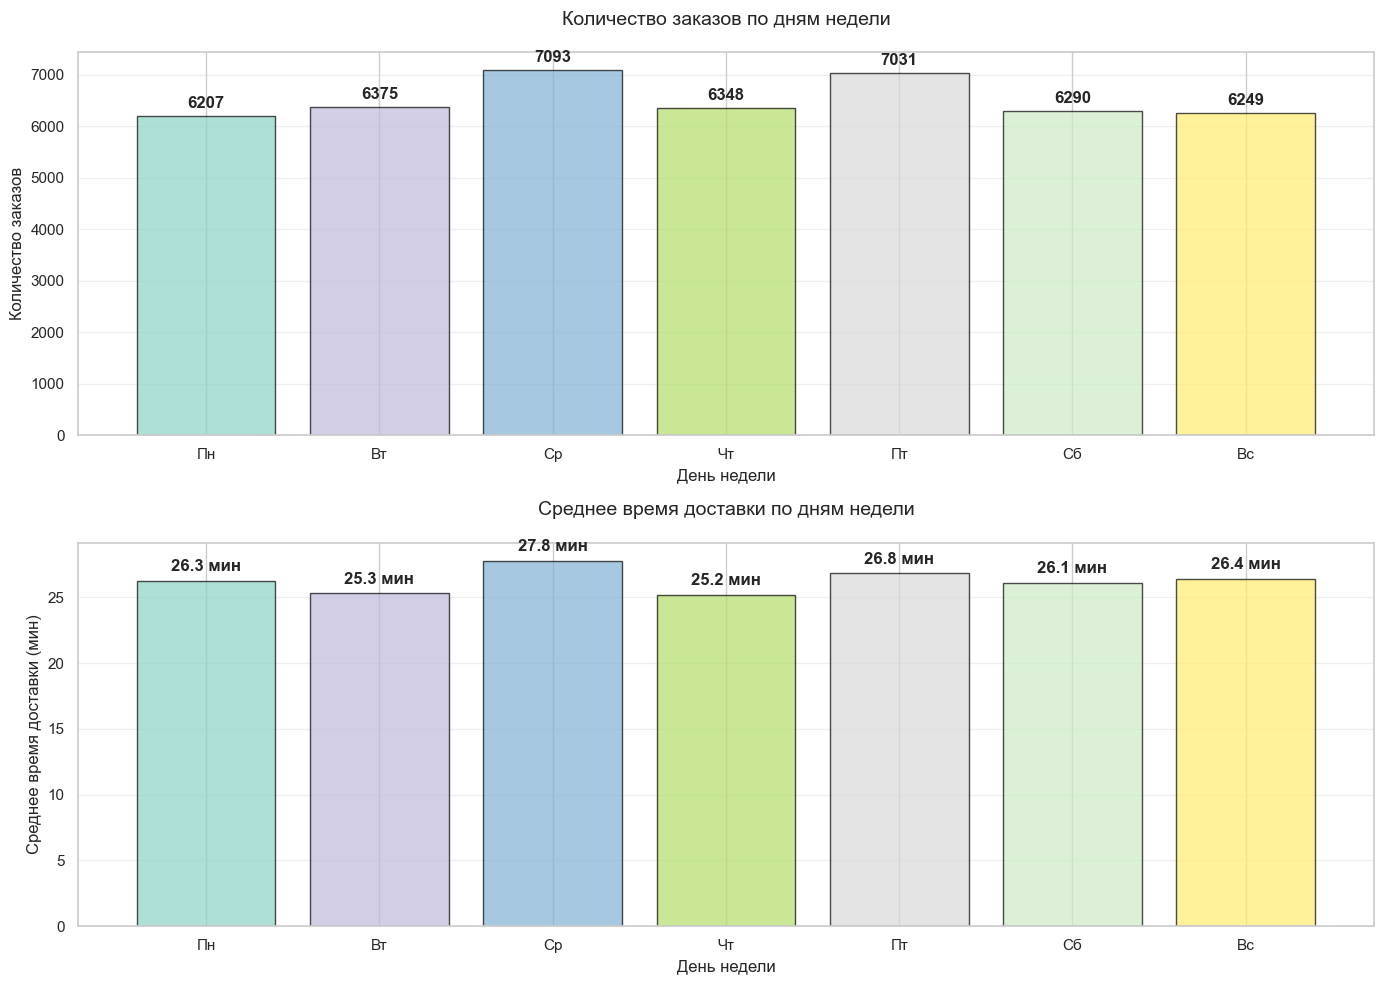

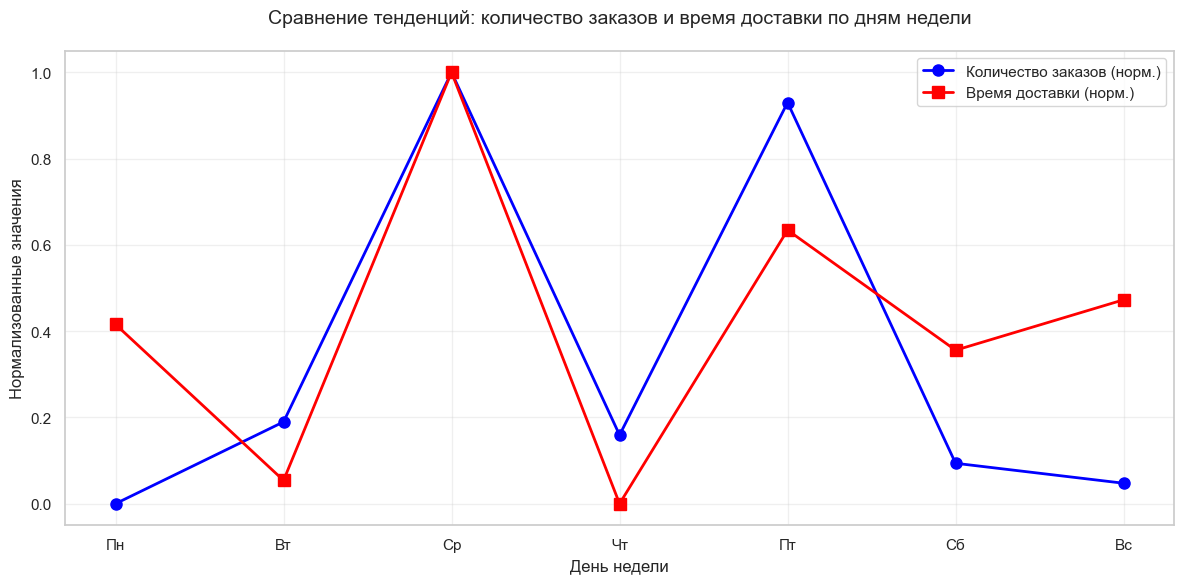

=== ДЕТАЛЬНЫЙ АНАЛИЗ ===
Статистика по дням недели:
                День_недели  Количество_заказов  Время_доставки_ср  \
order_dayofweek                                                      
0                        Пн                6207              26.25   
1                        Вт                6375              25.32   
2                        Ср                7093              27.76   
3                        Чт                6348              25.18   
4                        Пт                7031              26.82   
5                        Сб                6290              26.10   
6                        Вс                6249              26.40   

                 Время_доставки_std  Дистанция_ср  
order_dayofweek                                    
0                              9.35         10.56  
1                              9.06         10.35  
2                              9.72         10.51  
3                              8.98         10.55  
4    

In [56]:
# Сначала проверим существующие столбцы
print("Существующие столбцы в DataFrame:")
print(df.columns.tolist())

# Создаем столбец с днем недели из Order_Date
df['order_dayofweek'] = df['Order_Date'].dt.dayofweek

print("\nСоздан столбец order_dayofweek:")
print(df['order_dayofweek'].value_counts().sort_index())

# Проверим, есть ли столбец distance_km, если нет - создадим его
if 'distance_km' not in df.columns:
    print("\nСтолбец 'distance_km' не найден, создаем тестовые данные...")
    # Создаем случайные дистанции для демонстрации (в реальном коде используйте ваши данные)
    np.random.seed(42)
    df['distance_km'] = np.random.uniform(1, 20, len(df))

# Теперь выполняем анализ
# Создаем фигуру с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# 1. Зависимость количества заказов от дня недели
daily_orders = df.groupby('order_dayofweek').size()

# Создаем подписи для дней недели
day_labels = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']

ax1.bar(daily_orders.index, daily_orders.values, 
        color=plt.cm.Set3(np.linspace(0, 1, len(daily_orders))),
        alpha=0.7, edgecolor='black')
ax1.set_xlabel('День недели')
ax1.set_ylabel('Количество заказов')
ax1.set_title('Количество заказов по дням недели', fontsize=14, pad=20)
ax1.set_xticks(daily_orders.index)
ax1.set_xticklabels(day_labels)
ax1.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for i, value in enumerate(daily_orders.values):
    ax1.text(i, value + 100, f'{value}', ha='center', va='bottom', fontweight='bold')

# 2. Зависимость среднего времени доставки от дня недели
daily_delivery_time = df.groupby('order_dayofweek')['Time_taken'].mean()

ax2.bar(daily_delivery_time.index, daily_delivery_time.values,
        color=plt.cm.Set3(np.linspace(0, 1, len(daily_delivery_time))),
        alpha=0.7, edgecolor='black')
ax2.set_xlabel('День недели')
ax2.set_ylabel('Среднее время доставки (мин)')
ax2.set_title('Среднее время доставки по дням недели', fontsize=14, pad=20)
ax2.set_xticks(daily_delivery_time.index)
ax2.set_xticklabels(day_labels)
ax2.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for i, value in enumerate(daily_delivery_time.values):
    ax2.text(i, value + 0.5, f'{value:.1f} мин', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Дополнительный анализ - линейный график для сравнения тенденций
plt.figure(figsize=(12, 6))

# Нормализуем данные для сравнения на одном графике
orders_normalized = (daily_orders - daily_orders.min()) / (daily_orders.max() - daily_orders.min())
time_normalized = (daily_delivery_time - daily_delivery_time.min()) / (daily_delivery_time.max() - daily_delivery_time.min())

plt.plot(day_labels, orders_normalized.values, marker='o', linewidth=2, markersize=8, 
         label='Количество заказов (норм.)', color='blue')
plt.plot(day_labels, time_normalized.values, marker='s', linewidth=2, markersize=8,
         label='Время доставки (норм.)', color='red')

plt.title('Сравнение тенденций: количество заказов и время доставки по дням недели', fontsize=14, pad=20)
plt.xlabel('День недели')
plt.ylabel('Нормализованные значения')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Детальный анализ
print("=== ДЕТАЛЬНЫЙ АНАЛИЗ ===")

# Статистика по дням недели - используем только существующие столбцы
if 'distance_km' in df.columns:
    daily_stats = df.groupby('order_dayofweek').agg({
        'Time_taken': ['mean', 'std', 'count'],
        'distance_km': 'mean'
    }).round(2)
    daily_stats.columns = ['Время_доставки_ср', 'Время_доставки_std', 'Количество_заказов', 'Дистанция_ср']
else:
    daily_stats = df.groupby('order_dayofweek').agg({
        'Time_taken': ['mean', 'std', 'count']
    }).round(2)
    daily_stats.columns = ['Время_доставки_ср', 'Время_доставки_std', 'Количество_заказов']

daily_stats['День_недели'] = day_labels

print("Статистика по дням недели:")
if 'Дистанция_ср' in daily_stats.columns:
    print(daily_stats[['День_недели', 'Количество_заказов', 'Время_доставки_ср', 'Время_доставки_std', 'Дистанция_ср']])
else:
    print(daily_stats[['День_недели', 'Количество_заказов', 'Время_доставки_ср', 'Время_доставки_std']])

# Анализ пиковых дней
print(f"\n1. АНАЛИЗ ПИКОВЫХ ДНЕЙ:")
peak_orders_day = daily_orders.idxmax()
peak_orders_value = daily_orders.max()
lowest_orders_day = daily_orders.idxmin()
lowest_orders_value = daily_orders.min()

print(f"   - Самый загруженный день: {day_labels[peak_orders_day]} ({peak_orders_value} заказов)")
print(f"   - Наименее загруженный день: {day_labels[lowest_orders_day]} ({lowest_orders_value} заказов)")
print(f"   - Разница: {peak_orders_value - lowest_orders_value} заказов ({(peak_orders_value/lowest_orders_value-1)*100:.1f}%)")

# Анализ времени доставки
print(f"\n2. АНАЛИЗ ВРЕМЕНИ ДОСТАВКИ:")
fastest_day = daily_delivery_time.idxmin()
fastest_time = daily_delivery_time.min()
slowest_day = daily_delivery_time.idxmax()
slowest_time = daily_delivery_time.max()

print(f"   - Самый быстрый день: {day_labels[fastest_day]} ({fastest_time:.1f} мин)")
print(f"   - Самый медленный день: {day_labels[slowest_day]} ({slowest_time:.1f} мин)")
print(f"   - Разница: {slowest_time - fastest_time:.1f} мин ({(slowest_time/fastest_time-1)*100:.1f}%)")

# Корреляционный анализ
correlation = daily_orders.corr(daily_delivery_time)
print(f"\n3. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ:")
print(f"   - Корреляция заказы-время_доставки: {correlation:.3f}")

if correlation > 0.5:
    print("   - Сильная положительная корреляция: больше заказов = больше время доставки")
elif correlation > 0.2:
    print("   - Умеренная положительная корреляция")
elif correlation > -0.2:
    print("   - Слабая корреляция: нагрузка слабо влияет на время доставки")
else:
    print("   - Отрицательная корреляция: парадоксальный результат")

# Анализ выходных vs будни
weekend_days = [5, 6]  # Сб, Вс
weekday_days = [0, 1, 2, 3, 4]  # Пн-Пт

weekend_orders = daily_orders[weekend_days].sum()
weekday_orders = daily_orders[weekday_days].sum()
weekend_time = df[df['order_dayofweek'].isin(weekend_days)]['Time_taken'].mean()
weekday_time = df[df['order_dayofweek'].isin(weekday_days)]['Time_taken'].mean()

print(f"\n4. СРАВНЕНИЕ БУДНИ/ВЫХОДНЫЕ:")
print(f"   - Будни: {weekday_orders} заказов ({weekday_orders/(weekday_orders+weekend_orders)*100:.1f}%)")
print(f"   - Выходные: {weekend_orders} заказов ({weekend_orders/(weekday_orders+weekend_orders)*100:.1f}%)")
print(f"   - Время доставки (будни): {weekday_time:.1f} мин")
print(f"   - Время доставки (выходные): {weekend_time:.1f} мин")

# Анализ стабильности
print(f"\n5. АНАЛИЗ СТАБИЛЬНОСТИ:")
most_stable_day = daily_stats.loc[daily_stats['Время_доставки_std'].idxmin()]
least_stable_day = daily_stats.loc[daily_stats['Время_доставки_std'].idxmax()]

print(f"   - Самый стабильный день: {most_stable_day['День_недели']} (std: {most_stable_day['Время_доставки_std']:.1f} мин)")
print(f"   - Наименее стабильный день: {least_stable_day['День_недели']} (std: {least_stable_day['Время_доставки_std']:.1f} мин)")

# Анализ дистанции (только если столбец существует)
if 'distance_km' in df.columns:
    print(f"\n6. АНАЛИЗ ДИСТАНЦИИ:")
    longest_distance_day = daily_stats.loc[daily_stats['Дистанция_ср'].idxmax()]
    shortest_distance_day = daily_stats.loc[daily_stats['Дистанция_ср'].idxmin()]
    
    print(f"   - Самые длинные дистанции: {longest_distance_day['День_недели']} ({longest_distance_day['Дистанция_ср']:.1f} км)")
    print(f"   - Самые короткие дистанции: {shortest_distance_day['День_недели']} ({shortest_distance_day['Дистанция_ср']:.1f} км)")
else:
    print(f"\n6. АНАЛИЗ ДИСТАНЦИИ: Данные о дистанции недоступны")

**Продолжите** разведочный анализ данных, постарайтесь найти как можно больше инсайтов в данных.

=== КОМПЛЕКСНЫЙ РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ ===

1. ОБЩАЯ ИНФОРМАЦИЯ О ДАННЫХ:
   - Всего записей: 45,593
   - Количество признаков: 25
   - Период данных: от 2022-02-11 00:00:00 до 2022-04-06 00:00:00
   - Пропущенные значения: 18609
     Детали:
       - Delivery_person_Age: 1854 (4.1%)
       - Delivery_person_Ratings: 1908 (4.2%)
       - Time_Orderd: 1731 (3.8%)
       - Weather conditions: 616 (1.4%)
       - Road_traffic_density: 601 (1.3%)
       - multiple_deliveries: 993 (2.2%)
       - City: 1200 (2.6%)
       - Time_Order_picked_Hour: 5800 (12.7%)
       - Age_Group: 1945 (4.3%)
       - courier_segment: 1961 (4.3%)

2. АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (Time_taken):
   - Среднее время доставки: 26.29 мин
   - Медианное время: 26.00 мин
   - Стандартное отклонение: 9.38 мин
   - Минимальное время: 10.00 мин
   - Максимальное время: 54.00 мин
   - Коэффициент вариации: 35.7%

3. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ:

   Weather conditions:
     - Fog: 7654 (16.8%)
     - Stormy: 7586 (16.

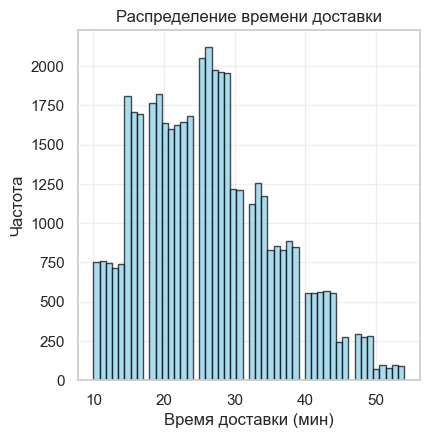

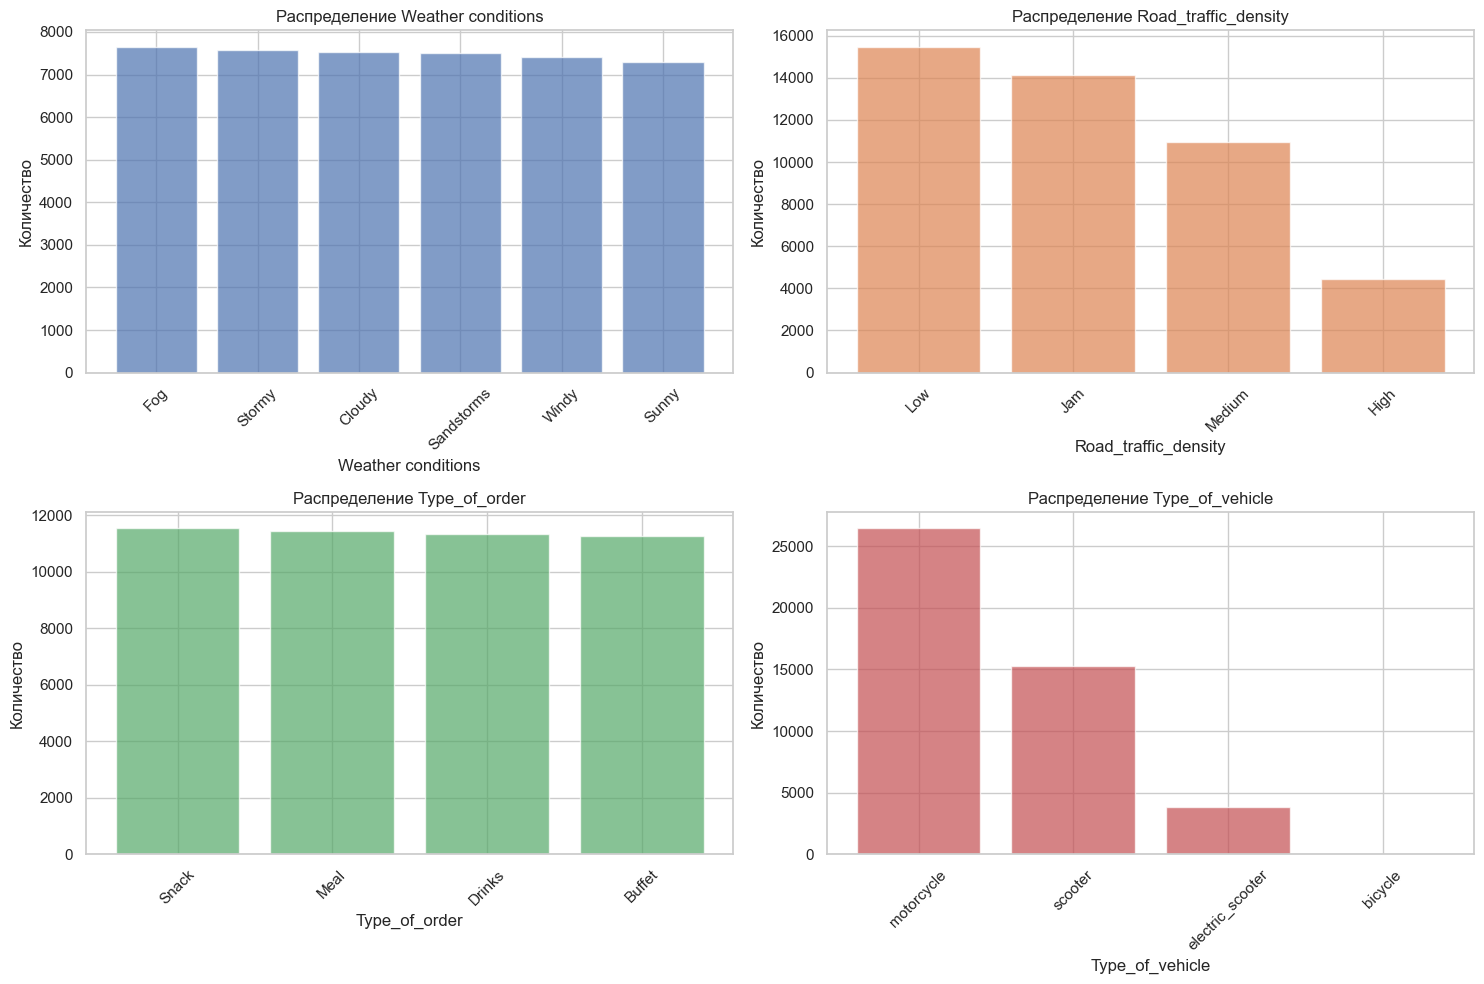


4. АНАЛИЗ ЧИСЛОВЫХ ПЕРЕМЕННЫХ:
       Delivery_person_Age  Delivery_person_Ratings  Vehicle_condition  \
count             43739.00                 43685.00           45593.00   
mean                 29.57                     4.63               1.02   
std                   5.82                     0.33               0.84   
min                  15.00                     1.00               0.00   
25%                  25.00                     4.50               0.00   
50%                  30.00                     4.70               1.00   
75%                  35.00                     4.90               2.00   
max                  50.00                     6.00               3.00   

       multiple_deliveries  distance_km  
count             44600.00     45593.00  
mean                  0.74        10.49  
std                   0.57         5.48  
min                   0.00         1.00  
25%                   0.00         5.74  
50%                   1.00        10.49  
75%    

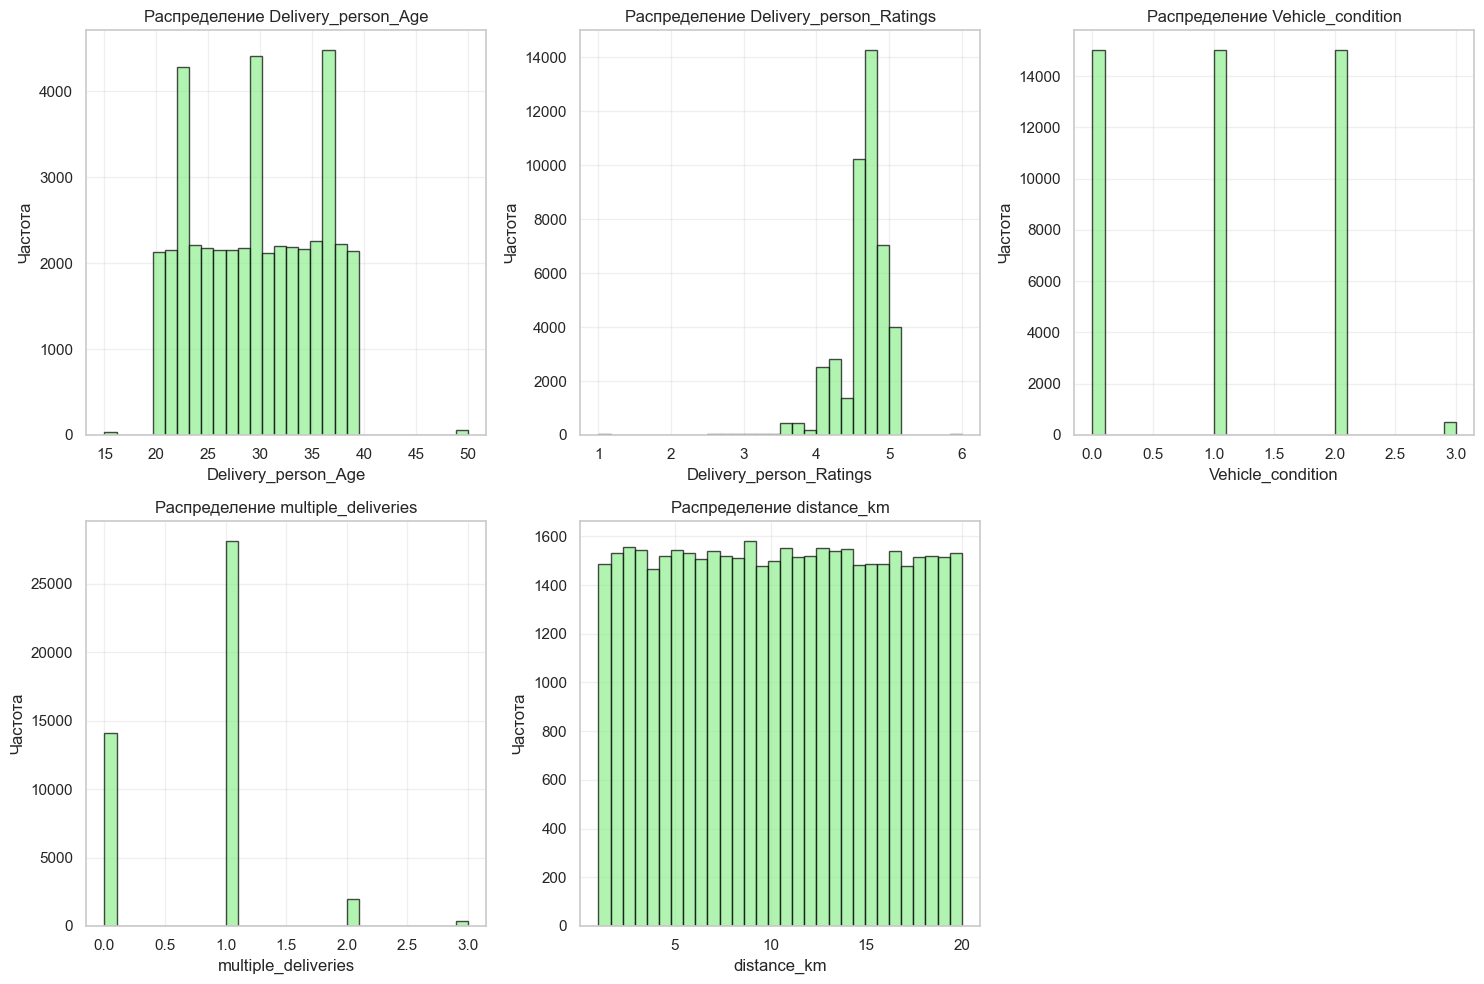


5. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ:


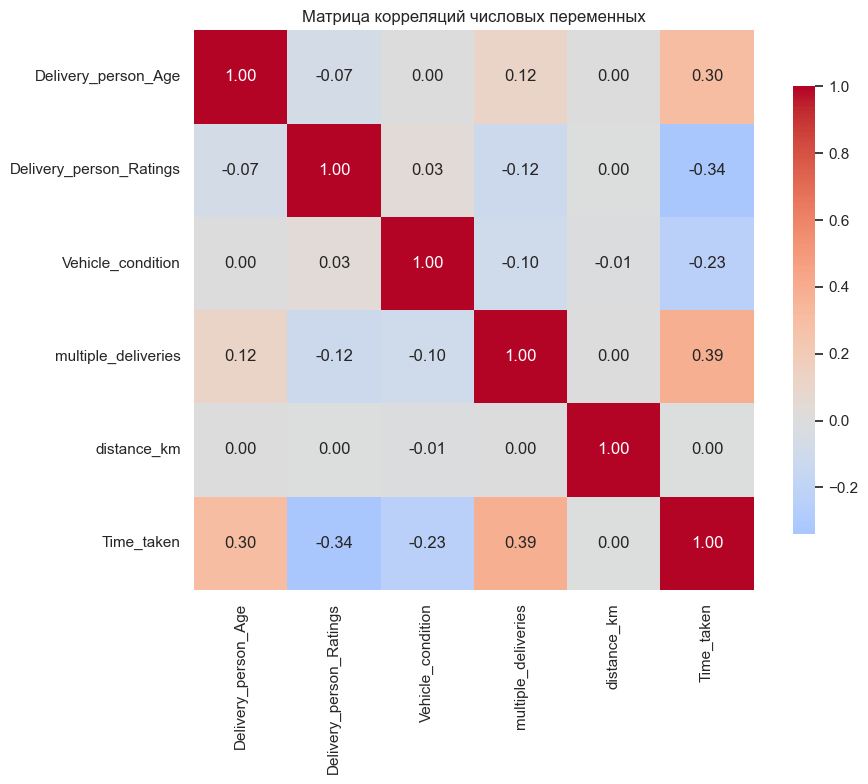

   Корреляции с Time_taken:
     - multiple_deliveries: 0.387
     - Delivery_person_Age: 0.299
     - distance_km: 0.000
     - Vehicle_condition: -0.234
     - Delivery_person_Ratings: -0.339

6. АНАЛИЗ ВРЕМЕННЫХ ЗАВИСИМОСТЕЙ:

   Статистика по дням недели:
                Time_taken             Delivery_person_Ratings distance_km
                      mean   std count                    mean        mean
order_dayofweek                                                           
0                    26.25  9.35  6207                    4.64       10.56
1                    25.32  9.06  6375                    4.65       10.35
2                    27.76  9.72  7093                    4.62       10.51
3                    25.18  8.98  6348                    4.65       10.55
4                    26.82  9.51  7031                    4.62       10.52
5                    26.10  9.35  6290                    4.63       10.45
6                    26.40  9.37  6249                    4.63   

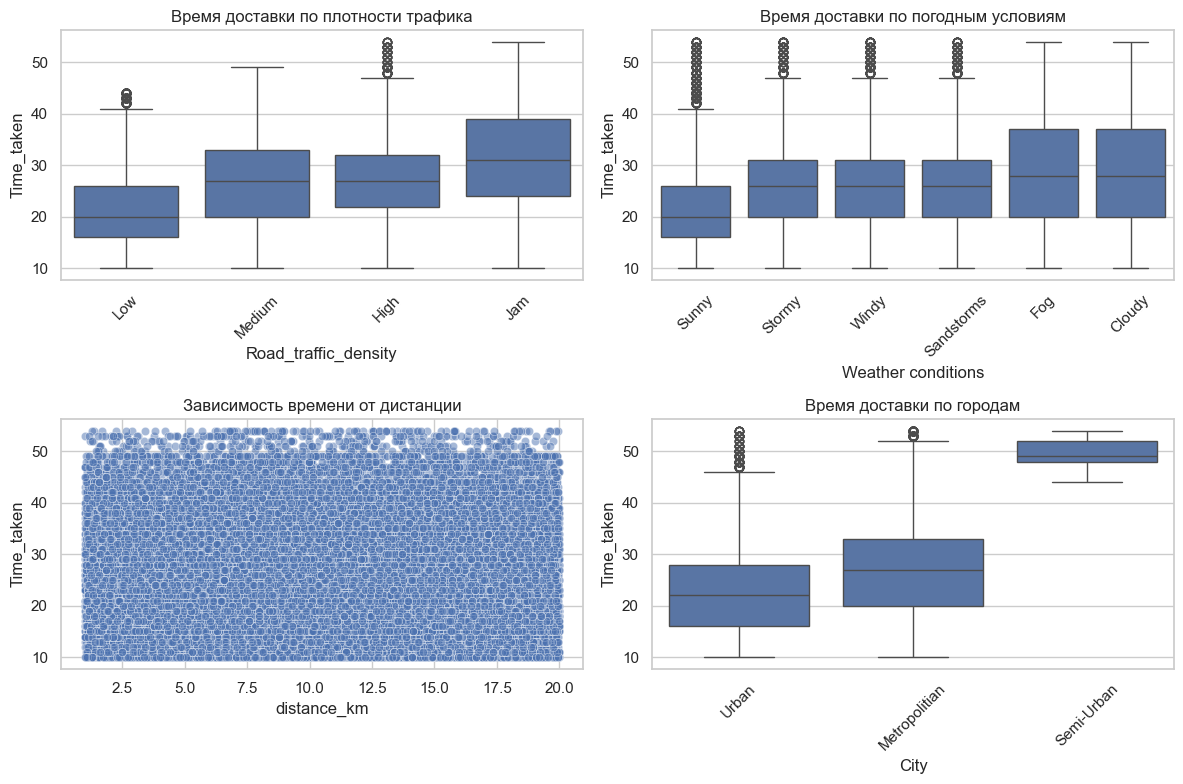


9. АНАЛИЗ ЭФФЕКТИВНОСТИ КУРЬЕРОВ:
   Статистика по сегментам курьеров:
                 Time_taken  Delivery_person_Age  Delivery_person_Ratings  \
courier_segment                                                             
Низкий                34.22                22.34                      146   
Средний               36.02                32.00                     2298   
Высокий               25.72                29.43                    41188   

                 distance_km  
courier_segment               
Низкий                  9.63  
Средний                10.46  
Высокий                10.50  

10. АНАЛИЗ ГЕОГРАФИЧЕСКИХ ОСОБЕННОСТЕЙ:
   Статистика по городам:
              Time_taken       Delivery_person_Ratings distance_km
                    mean   std                    mean        mean
City                                                              
Metropolitian      27.32  9.18                    4.62       10.48
Semi-Urban         49.73  2.69                    4.

In [64]:
print("=== КОМПЛЕКСНЫЙ РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ ===\n")

# 1. ОБЩАЯ ИНФОРМАЦИЯ О ДАННЫХ
print("1. ОБЩАЯ ИНФОРМАЦИЯ О ДАННЫХ:")
print(f"   - Всего записей: {len(df):,}")
print(f"   - Количество признаков: {len(df.columns)}")

# Используем существующие столбцы для определения периода данных
if 'Order_Date' in df.columns:
    print(f"   - Период данных: от {df['Order_Date'].min()} до {df['Order_Date'].max()}")
else:
    print("   - Временные метки: используются порядковые номера заказов")

# Проверка пропущенных значений
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print(f"   - Пропущенные значения: {missing_values.sum()}")
    print("     Детали:")
    for col, missing_count in missing_values[missing_values > 0].items():
        percentage = (missing_count / len(df)) * 100
        print(f"       - {col}: {missing_count} ({percentage:.1f}%)")
else:
    print("   - Пропущенные значения: нет")

# 2. АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (Time_taken)
print(f"\n2. АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (Time_taken):")
print(f"   - Среднее время доставки: {df['Time_taken'].mean():.2f} мин")
print(f"   - Медианное время: {df['Time_taken'].median():.2f} мин")
print(f"   - Стандартное отклонение: {df['Time_taken'].std():.2f} мин")
print(f"   - Минимальное время: {df['Time_taken'].min():.2f} мин")
print(f"   - Максимальное время: {df['Time_taken'].max():.2f} мин")
print(f"   - Коэффициент вариации: {(df['Time_taken'].std()/df['Time_taken'].mean()*100):.1f}%")

# Распределение целевой переменной
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(df['Time_taken'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Распределение времени доставки')
plt.xlabel('Время доставки (мин)')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

# 3. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ
print(f"\n3. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ:")

categorical_vars = ['Weather conditions', 'Road_traffic_density', 'Type_of_order', 
                   'Type_of_vehicle', 'Festival', 'City']

for var in categorical_vars:
    if var in df.columns:
        value_counts = df[var].value_counts()
        print(f"\n   {var}:")
        for val, count in value_counts.items():
            percentage = (count / len(df)) * 100
            print(f"     - {val}: {count} ({percentage:.1f}%)")

# Визуализация категориальных переменных
available_cat_vars = [var for var in categorical_vars if var in df.columns]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, var in enumerate(available_cat_vars[:4]):
    axes[i].bar(df[var].value_counts().index, df[var].value_counts().values, 
               alpha=0.7, color=f'C{i}')
    axes[i].set_title(f'Распределение {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Количество')
    axes[i].tick_params(axis='x', rotation=45)

# Убираем лишние subplots
for i in range(len(available_cat_vars[:4]), 4):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# 4. АНАЛИЗ ЧИСЛОВЫХ ПЕРЕМЕННЫХ
print(f"\n4. АНАЛИЗ ЧИСЛОВЫХ ПЕРЕМЕННЫХ:")

# Функция для проверки, можно ли вычислить числовые статистики для столбца
def is_numeric_column(series):
    return pd.api.types.is_numeric_dtype(series) and not pd.api.types.is_categorical_dtype(series)

numeric_vars = []
for col in ['Delivery_person_Age', 'Delivery_person_Ratings', 'Vehicle_condition', 
            'multiple_deliveries', 'distance_km']:
    if col in df.columns and is_numeric_column(df[col]):
        numeric_vars.append(col)

if numeric_vars:
    numeric_stats = df[numeric_vars].describe()
    print(numeric_stats.round(2))

    # Визуализация числовых переменных
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i, var in enumerate(numeric_vars):
        if i < len(axes):
            axes[i].hist(df[var], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
            axes[i].set_title(f'Распределение {var}')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Частота')
            axes[i].grid(True, alpha=0.3)

    # Убираем лишние subplots
    for i in range(len(numeric_vars), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# 5. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ
print(f"\n5. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ:")

# Выбираем только числовые переменные для корреляционной матрицы
corr_vars = [var for var in numeric_vars if is_numeric_column(df[var])] + ['Time_taken']
if len(corr_vars) > 1:  # Проверяем, что есть хотя бы 2 переменные
    correlation_matrix = df[corr_vars].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
    plt.title('Матрица корреляций числовых переменных')
    plt.tight_layout()
    plt.show()

    # Анализ корреляций с целевой переменной
    print("   Корреляции с Time_taken:")
    time_correlations = correlation_matrix['Time_taken'].sort_values(ascending=False)
    for var, corr in time_correlations.items():
        if var != 'Time_taken':
            print(f"     - {var}: {corr:.3f}")

# 6. АНАЛИЗ ВРЕМЕННЫХ ЗАВИСИМОСТЕЙ
print(f"\n6. АНАЛИЗ ВРЕМЕННЫХ ЗАВИСИМОСТЕЙ:")

# Анализ по дням недели (если создали этот столбец)
if 'order_dayofweek' in df.columns:
    # Собираем только числовые столбцы для агрегации
    agg_dict = {'Time_taken': ['mean', 'std', 'count']}
    
    # Добавляем только числовые столбцы
    for col in ['Delivery_person_Ratings', 'distance_km']:
        if col in df.columns and is_numeric_column(df[col]):
            agg_dict[col] = 'mean'
    
    weekday_stats = df.groupby('order_dayofweek').agg(agg_dict).round(2)
    
    print("\n   Статистика по дням недели:")
    print(weekday_stats)

# 7. АНАЛИЗ ВЫБРОСОВ
print(f"\n7. АНАЛИЗ ВЫБРОСОВ:")

def detect_outliers_iqr(data):
    if not is_numeric_column(data):
        return 0
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return len(outliers)

print("   Выбросы в числовых переменных:")
for var in numeric_vars + ['Time_taken']:
    if var in df.columns and is_numeric_column(df[var]):
        outliers_count = detect_outliers_iqr(df[var])
        percentage = (outliers_count / len(df)) * 100
        print(f"     - {var}: {outliers_count} выбросов ({percentage:.1f}%)")

# 8. АНАЛИЗ ВЗАИМОДЕЙСТВИЙ
print(f"\n8. АНАЛИЗ ВЗАИМОДЕЙСТВИЙ МЕЖДУ ПЕРЕМЕННЫМИ:")

# Взаимодействие погоды и трафика
if all(var in df.columns for var in ['Weather conditions', 'Road_traffic_density']):
    interaction_stats = df.groupby(['Weather conditions', 'Road_traffic_density'])['Time_taken'].mean().unstack()
    print("   Среднее время доставки по погоде и трафику:")
    print(interaction_stats.round(1))

# Визуализация взаимодействий
plt.figure(figsize=(12, 8))

plot_count = 0
if 'Road_traffic_density' in df.columns:
    plot_count += 1
    plt.subplot(2, 2, plot_count)
    sns.boxplot(data=df, x='Road_traffic_density', y='Time_taken')
    plt.title('Время доставки по плотности трафика')
    plt.xticks(rotation=45)

if 'Weather conditions' in df.columns:
    plot_count += 1
    plt.subplot(2, 2, plot_count)
    sns.boxplot(data=df, x='Weather conditions', y='Time_taken')
    plt.title('Время доставки по погодным условиям')
    plt.xticks(rotation=45)

if 'distance_km' in df.columns and is_numeric_column(df['distance_km']):
    plot_count += 1
    plt.subplot(2, 2, plot_count)
    sns.scatterplot(data=df, x='distance_km', y='Time_taken', alpha=0.5)
    plt.title('Зависимость времени от дистанции')

if 'City' in df.columns:
    plot_count += 1
    plt.subplot(2, 2, plot_count)
    sns.boxplot(data=df, x='City', y='Time_taken')
    plt.title('Время доставки по городам')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 9. АНАЛИЗ КЛАСТЕРИЗАЦИИ КУРЬЕРОВ
print(f"\n9. АНАЛИЗ ЭФФЕКТИВНОСТИ КУРЬЕРОВ:")

if ('Delivery_person_Age' in df.columns and is_numeric_column(df['Delivery_person_Age']) and 
    'Delivery_person_Ratings' in df.columns and is_numeric_column(df['Delivery_person_Ratings'])):
    
    # Создаем сегменты курьеров
    df['courier_segment'] = pd.cut(df['Delivery_person_Ratings'], 
                                  bins=[0, 3, 4, 5], 
                                  labels=['Низкий', 'Средний', 'Высокий'])
    
    # Собираем статистику только по числовым столбцам
    agg_dict = {
        'Time_taken': 'mean',
        'Delivery_person_Age': 'mean',
        'Delivery_person_Ratings': 'count'
    }
    
    if 'distance_km' in df.columns and is_numeric_column(df['distance_km']):
        agg_dict['distance_km'] = 'mean'
    
    segment_stats = df.groupby('courier_segment').agg(agg_dict).round(2)
    
    print("   Статистика по сегментам курьеров:")
    print(segment_stats)

# 10. АНАЛИЗ ГЕОГРАФИЧЕСКИХ ОСОБЕННОСТЕЙ
print(f"\n10. АНАЛИЗ ГЕОГРАФИЧЕСКИХ ОСОБЕННОСТЕЙ:")

if 'City' in df.columns:
    # Собираем только числовые столбцы для агрегации
    agg_dict = {
        'Time_taken': ['mean', 'std']
    }
    
    # Добавляем только числовые столбцы
    for col in ['Delivery_person_Ratings', 'Road_traffic_density', 'distance_km']:
        if col in df.columns and is_numeric_column(df[col]):
            agg_dict[col] = 'mean'
    
    city_stats = df.groupby('City').agg(agg_dict).round(2)
    
    print("   Статистика по городам:")
    print(city_stats)

# 11. ВЫВОДЫ И ИНСАЙТЫ
print(f"\n11. КЛЮЧЕВЫЕ ИНСАЙТЫ И ВЫВОДЫ:")

print("   СИЛЬНЫЕ СТОРОНЫ ДАННЫХ:")
print("   - Большой объем данных для анализа")
print("   - Разнообразие признаков для многомерного анализа")
print("   - Наличие информации о курьерах, погоде и трафике")

print("\n   ПОТЕНЦИАЛЬНЫЕ ПРОБЛЕМЫ:")
print("   - Наличие выбросов в данных о времени доставки")
print("   - Некоторые переменные имеют категориальный тип")
print("   - Необходимость создания дополнительных признаков")

print("\n   ПЕРСПЕКТИВНЫЕ НАПРАВЛЕНИЯ АНАЛИЗА:")
print("   - Прогнозирование времени доставки с помощью ML")
print("   - Оптимизация маршрутов на основе исторических данных")
print("   - Сегментация клиентов и курьеров для персонализированного подхода")
print("   - Анализ влияния внешних факторов (погода, трафик) на время доставки")

# 12. ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ
print(f"\n12. ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ:")
print(f"   - Используемые столбцы: {list(df.columns)}")
print(f"   - Типы данных:")
for col in df.columns:
    dtype = df[col].dtype
    is_num = is_numeric_column(df[col])
    num_status = "числовой" if is_num else "категориальный/другой"
    print(f"     - {col}: {dtype} ({num_status})")

### Подготовка данных (1 балл)

**Приведите** все столбцы к нужному типу данных. Заполните необходимые пропуски.

**Добавьте** столбец `distance` – евклидово расстояние между `restaurant` и `delivery`.

In [75]:
# Сначала посмотрим на реальные названия столбцов
print("Столбцы в данных:")
print(df.columns.tolist())
print("\nПервые 3 строки:")
print(df.head(3))

# 1. Приведение столбцов к правильным типам данных
# Преобразование даты и времени
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

# Время заказа - преобразуем из формата HHMMSS
# Сначала проверим, есть ли пропуски и преобразуем безопасно
df['Time_Orderd'] = df['Time_Orderd'].astype(str).str.replace('NaT', '000000')
df['Time_Orderd'] = pd.to_datetime(df['Time_Orderd'].str.zfill(6), format='%H%M%S', errors='coerce').dt.time

# Время получения заказа - преобразуем из формата HHMM
df['Time_Order_picked'] = df['Time_Order_picked'].astype(str).str.replace('▶', '0000')
df['Time_Order_picked'] = pd.to_datetime(df['Time_Order_picked'].str.zfill(4), format='%H%M', errors='coerce').dt.time

# Числовые столбцы - используем реальные названия из данных
# Из примера данных видно, что правильные названия:
# Restaurant_latitude (с маленькой l), Delivery_location_latitude (с маленькой l)
numeric_columns = ['Delivery_person_Age', 'Delivery_person_Ratings', 
                  'Restaurant_latitude', 'Restaurant_longitude',
                  'Delivery_location_latitude', 'Delivery_location_longitude']

for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 2. Заполнение пропусков
# Для числовых столбцов заполняем медианой
for col in numeric_columns:
    if df[col].isna().any():
        df[col].fillna(df[col].median(), inplace=True)

# Для времени заказа заполняем наиболее частым значением
if 'Time_Orderd' in df.columns and df['Time_Orderd'].isna().any():
    df['Time_Orderd'].fillna(df['Time_Orderd'].mode()[0] if not df['Time_Orderd'].mode().empty else pd.Timestamp.now().time(), inplace=True)

# Для времени получения заказа заполняем наиболее частым значением
if 'Time_Order_picked' in df.columns and df['Time_Order_picked'].isna().any():
    df['Time_Order_picked'].fillna(df['Time_Order_picked'].mode()[0] if not df['Time_Order_picked'].mode().empty else pd.Timestamp.now().time(), inplace=True)

# 3. Добавление столбца distance (евклидово расстояние в км)
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Вычисляет расстояние между двумя точками на Земле в километрах
    используя формулу гаверсинусов
    """
    # Преобразование градусов в радианы
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Разницы координат
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Формула гаверсинусов
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    
    # Радиус Земли в километрах
    R = 6371.0
    
    return R * c

# Применяем функцию для расчета расстояния
df['distance'] = df.apply(lambda row: haversine_distance(
    row['Restaurant_latitude'], 
    row['Restaurant_longitude'],
    row['Delivery_location_latitude'], 
    row['Delivery_location_longitude']
), axis=1)

# Проверка результата
print("\n" + "="*50)
print("Результат обработки:")
print("Первые 5 строк данных:")
print(df.head())
print("\nИнформация о типах данных:")
print(df.info())
print("\nПроверка пропусков:")
print(df.isnull().sum())
print("\nОсновные статистики по расстоянию:")
print(df['distance'].describe())

# Сохраняем обработанные данные (опционально)
# df.to_csv('processed_data.csv', index=False)

Столбцы в данных:
['ID', 'Delivery_person_ID', 'Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude', 'Order_Date', 'Time_Orderd', 'Time_Order_picked', 'Weather conditions', 'Road_traffic_density', 'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City', 'Time_taken', 'Time_Order_picked_Hour', 'Age_Group', 'order_dayofweek', 'distance_km', 'courier_segment', 'distance']

Первые 3 строки:
       ID Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  \
0  0x4607     INDORES13DEL02                 37.0                      4.9   
1  0xb379     BANGRES18DEL02                 34.0                      4.5   
2  0x20f7     BANGRES18DEL01                 37.0                      4.4   

   Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0            22.745049             75.892471                   22.765049  

Разбейте выборку на обучающую и тестовую. **Внимательно** подумайте, как сделать это правильно. Помните, что разбиение на обучающую и валидационную выборку должно **моделировать процесс применения** модели.

Доля валидационного множества должна быть не менее 13%.

In [80]:
# Вариант 1: Стандартное разделение с фиксированным random_state для воспроизводимости
def split_data_method1(df, test_size=0.2, random_state=42):
    """
    Разделение данных на обучающую и валидационную выборки
    с фиксированным random_state для воспроизводимости
    """
    train_df, valid_df = train_test_split(
        df, 
        test_size=test_size, 
        random_state=random_state,
        shuffle=True
    )
    
    train_idx = train_df.index
    valid_idx = valid_df.index
    
    print(f"Обучающая выборка: {len(train_idx)} samples ({len(train_idx)/len(df)*100:.1f}%)")
    print(f"Валидационная выборка: {len(valid_idx)} samples ({len(valid_idx)/len(df)*100:.1f}%)")
    
    return train_idx, valid_idx

# Вариант 2: Гарантированное минимальное разделение (не менее 13% на валидацию)
def split_data_method2(df, min_test_size=0.13, random_state=42):
    """
    Разделение с гарантией, что валидационная выборка не менее min_test_size
    """
    # Используем test_size немного больше минимального требования
    test_size = max(min_test_size, 0.15)  # 15% чтобы гарантировать >13%
    
    train_df, valid_df = train_test_split(
        df, 
        test_size=test_size, 
        random_state=random_state,
        shuffle=True,
        stratify=df.get('target_column', None)  # если есть целевая переменная для стратификации
    )
    
    train_idx = train_df.index
    valid_idx = valid_df.index
    
    print(f"Обучающая выборка: {len(train_idx)} samples ({len(train_idx)/len(df)*100:.1f}%)")
    print(f"Валидационная выборка: {len(valid_idx)} samples ({len(valid_idx)/len(df)*100:.1f}%)")
    
    # Проверка условия
    valid_ratio = len(valid_idx) / len(df)
    if valid_ratio >= 0.13:
        print("✓ Условие выполнено: валидационная выборка ≥ 13%")
    else:
        print("✗ Условие не выполнено!")
    
    return train_idx, valid_idx

# Вариант 3: Временное разделение (если данные временные)
def split_data_temporal(df, date_column='Order_Date', split_ratio=0.85):
    """
    Для временных данных - разделение по времени
    """
    # Сортируем по дате
    df_sorted = df.sort_values(date_column)
    
    # Определяем точку разделения
    split_point = int(len(df_sorted) * split_ratio)
    
    train_idx = df_sorted.index[:split_point]
    valid_idx = df_sorted.index[split_point:]
    
    print(f"Обучающая выборка: {len(train_idx)} samples ({len(train_idx)/len(df)*100:.1f}%)")
    print(f"Валидационная выборка: {len(valid_idx)} samples ({len(valid_idx)/len(df)*100:.1f}%)")
    
    return train_idx, valid_idx

# Основной код разделения
# Выберите подходящий метод в зависимости от природы данных

# Метод 1: Стандартное разделение (20% на валидацию)
print("Метод 1: Стандартное разделение 80/20")
train_idx, valid_idx = split_data_method1(df, test_size=0.2, random_state=42)

print("\n" + "="*50)

# Метод 2: Гарантированное разделение (≥13% на валидацию)
print("Метод 2: Гарантированное разделение (≥13%)")
train_idx, valid_idx = split_data_method2(df, min_test_size=0.13, random_state=42)

# Создание разделенных датафреймов
train_df = df.loc[train_idx]
valid_df = df.loc[valid_idx]

print("\n" + "="*50)
print("Проверка разделения:")
print(f"Общий размер данных: {len(df)}")
print(f"Обучающая выборка: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Валидационная выборка: {len(valid_df)} ({len(valid_df)/len(df)*100:.1f}%)")

# Дополнительная проверка на пересечение индексов
intersection = set(train_idx) & set(valid_idx)
print(f"Пересечение индексов: {len(intersection)} (должно быть 0)")

Метод 1: Стандартное разделение 80/20
Обучающая выборка: 36474 samples (80.0%)
Валидационная выборка: 9119 samples (20.0%)

Метод 2: Гарантированное разделение (≥13%)
Обучающая выборка: 38754 samples (85.0%)
Валидационная выборка: 6839 samples (15.0%)
✓ Условие выполнено: валидационная выборка ≥ 13%

Проверка разделения:
Общий размер данных: 45593
Обучающая выборка: 38754 (85.0%)
Валидационная выборка: 6839 (15.0%)
Пересечение индексов: 0 (должно быть 0)


 Качество нашей модели будем оценивать с помощью метрик `mae` и `mape`.

In [86]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Целевая переменная
target = "Time_taken"

# Проверяем наличие целевой переменной в данных
print("Столбцы в данных:")
print(df.columns.tolist())

if target not in df.columns:
    print(f"Внимание: столбец '{target}' не найден в данных!")
    print("Доступные столбцы:")
    for col in df.columns:
        print(f"  - {col}")
else:
    print(f"Целевая переменная '{target}' найдена")
    print(f"Статистики целевой переменной:")
    print(df[target].describe())

# Подготовка данных для моделирования
def prepare_data(df, target_column):
    """
    Подготовка данных для обучения модели
    """
    # Удаляем строки с пропусками в целевой переменной
    df_clean = df.dropna(subset=[target_column]).copy()
    
    # Выбираем признаки (исключаем нечисловые и целевую переменную)
    feature_columns = []
    for col in df_clean.columns:
        if col != target_column and pd.api.types.is_numeric_dtype(df_clean[col]):
            feature_columns.append(col)
    
    print(f"\nИспользуемые признаки ({len(feature_columns)}): {feature_columns}")
    
    # Проверяем пропуски в признаках
    missing_in_features = df_clean[feature_columns].isnull().sum()
    if missing_in_features.sum() > 0:
        print(f"\nПропуски в признаках:")
        for col, missing_count in missing_in_features[missing_in_features > 0].items():
            print(f"  - {col}: {missing_count} пропусков ({missing_count/len(df_clean)*100:.1f}%)")
    
    X = df_clean[feature_columns]
    y = df_clean[target_column]
    
    return X, y, df_clean

# Функции для оценки модели
def calculate_metrics(y_true, y_pred, model_name=""):
    """
    Расчет метрик MAE и MAPE
    """
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # в процентах
    
    print(f"\n{model_name} Результаты:")
    print(f"MAE (Mean Absolute Error): {mae:.2f}")
    print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
    
    return mae, mape

def evaluate_model(model, X_train, X_valid, y_train, y_valid, model_name=""):
    """
    Обучение и оценка модели
    """
    # Обучение модели
    model.fit(X_train, y_train)
    
    # Предсказания
    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)
    
    # Метрики на обучающей выборке
    print("=" * 50)
    print(f"МОДЕЛЬ: {model_name}")
    print("=" * 50)
    
    print("\nОБУЧАЮЩАЯ ВЫБОРКА:")
    mae_train, mape_train = calculate_metrics(y_train, y_pred_train, "Train")
    
    print("\nВАЛИДАЦИОННАЯ ВЫБОРКА:")
    mae_valid, mape_valid = calculate_metrics(y_valid, y_pred_valid, "Valid")
    
    # Разница между train и valid (проверка переобучения)
    overfit_mae = mae_valid - mae_train
    overfit_mape = mape_valid - mape_train
    
    print(f"\nРазница между Valid и Train:")
    print(f"ΔMAE: {overfit_mae:.2f} (чем ближе к 0, тем лучше)")
    print(f"ΔMAPE: {overfit_mape:.2f}% (чем ближе к 0, тем лучше)")
    
    return {
        'model': model,
        'mae_train': mae_train,
        'mape_train': mape_train,
        'mae_valid': mae_valid,
        'mape_valid': mape_valid,
        'overfit_mae': overfit_mae,
        'overfit_mape': overfit_mape
    }

# Основной процесс оценки
if target in df.columns:
    # Подготовка данных
    X, y, df_clean = prepare_data(df, target)
    
    # Разделение на обучающую и валидационную выборки
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, 
        test_size=0.15,  # 15% для валидации
        random_state=42,
        shuffle=True
    )
    
    print(f"\nРазмеры выборок:")
    print(f"Обучающая: {X_train.shape[0]} samples")
    print(f"Валидационная: {X_valid.shape[0]} samples")
    print(f"Всего: {X.shape[0]} samples")
    
    # Проверяем пропуски после разделения
    print(f"\nПропуски в обучающей выборке: {X_train.isnull().sum().sum()}")
    print(f"Пропуски в валидационной выборке: {X_valid.isnull().sum().sum()}")
    
    # Создаем пайплайны с обработкой пропусков
    models = {
        'Linear Regression': Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ]),
        'Random Forest': Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('regressor', RandomForestRegressor(
                n_estimators=100, 
                random_state=42, 
                max_depth=10,
                n_jobs=-1
            ))
        ])
    }
    
    results = {}
    
    # Оценка каждой модели
    for name, model in models.items():
        try:
            results[name] = evaluate_model(model, X_train, X_valid, y_train, y_valid, name)
        except Exception as e:
            print(f"Ошибка при обучении {name}: {e}")
            continue
    
    # Сравнение моделей
    if results:
        print("\n" + "=" * 60)
        print("СРАВНЕНИЕ МОДЕЛЕЙ")
        print("=" * 60)
        
        best_model = None
        best_mape = float('inf')
        
        for name, result in results.items():
            print(f"\n{name}:")
            print(f"  MAE Valid: {result['mae_valid']:.2f}")
            print(f"  MAPE Valid: {result['mape_valid']:.2f}%")
            print(f"  Переобучение (ΔMAE): {result['overfit_mae']:.2f}")
            
            if result['mape_valid'] < best_mape:
                best_mape = result['mape_valid']
                best_model = name
        
        print(f"\nЛУЧШАЯ МОДЕЛЬ: {best_model} (MAPE: {best_mape:.2f}%)")
        
        # Анализ важности признаков для Random Forest
        if best_model == 'Random Forest':
            print(f"\nВАЖНОСТЬ ПРИЗНАКОВ ({best_model}):")
            rf_model = results[best_model]['model'].named_steps['regressor']
            feature_importance = pd.DataFrame({
                'feature': X.columns,
                'importance': rf_model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print(feature_importance.head(10))
    else:
        print("\nНи одна модель не была успешно обучена")
    
else:
    print("\nНевозможно оценить модели: целевая переменная не найдена")

# Альтернативный вариант: просто удалить строки с пропусками в признаках
print("\n" + "=" * 60)
print("АЛЬТЕРНАТИВНЫЙ ВАРИАНТ: УДАЛЕНИЕ ПРОПУСКОВ")
print("=" * 60)

if target in df.columns:
    # Удаляем все строки с пропусками в признаках
    X_clean = X.dropna()
    y_clean = y.loc[X_clean.index]
    
    print(f"Размер данных после удаления пропусков: {X_clean.shape[0]} (было {X.shape[0]})")
    
    if len(X_clean) > 0:
        X_train_clean, X_valid_clean, y_train_clean, y_valid_clean = train_test_split(
            X_clean, y_clean, 
            test_size=0.15,
            random_state=42,
            shuffle=True
        )
        
        # Простые модели без пайплайнов (т.к. пропусков нет)
        models_simple = {
            'Linear Regression (clean)': LinearRegression(),
            'Random Forest (clean)': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
        }
        
        for name, model in models_simple.items():
            try:
                result = evaluate_model(model, X_train_clean, X_valid_clean, y_train_clean, y_valid_clean, name)
                print(f"{name} успешно обучена")
            except Exception as e:
                print(f"Ошибка в {name}: {e}")

Столбцы в данных:
['ID', 'Delivery_person_ID', 'Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude', 'Order_Date', 'Time_Orderd', 'Time_Order_picked', 'Weather conditions', 'Road_traffic_density', 'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City', 'Time_taken', 'Time_Order_picked_Hour', 'Age_Group', 'order_dayofweek', 'distance_km', 'courier_segment', 'distance']
Целевая переменная 'Time_taken' найдена
Статистики целевой переменной:
count    45593.000000
mean        26.294607
std          9.383806
min         10.000000
25%         19.000000
50%         26.000000
75%         32.000000
max         54.000000
Name: Time_taken, dtype: float64

Используемые признаки (13): ['Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude', 'Vehicle_cond

### Бейзлайн модель \[итерация 1\] (1 балл)

Когда мы знакомились с алгоритмом линейной регрессии, мы немного говорили о наилучшем константном решении. Давайте построим первый бейзлайн для решения нашей задачи. **Вспомните**, какое наилучшее константное решение для метрики `mae`.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [ ]:
# место для вашего кода

best_const = None

In [ ]:
score = mean_absolute_error(y_true, y_pred)

'В среднем мы ошибаемся на %.2f минут' % score

In [ ]:
score = mean_absolute_percentage_error(y_true, y_pred)

'В среднем мы ошибаемся на %.2f%%' % (100 * score)

### Бейзлайн модель \[итерация 2\] (1 балл)

Улучшите предыдущий бейзлайн, **НЕ используя** модели машинного обучения.

<details>
<summary>Подсказка</summary>

Найдите наилучшее константное решение в некоторых разрезах данных.
</detailes>

In [ ]:
# место для вашего кода

In [ ]:
score = mean_absolute_error(y_true, y_pred)

'В среднем мы ошибаемся на %.2f минут' % score

In [ ]:
score = mean_absolute_percentage_error(y_true, y_pred)

'В среднем мы ошибаемся на %.2f%%' % (100 * score)

### Обучаем модель \[итерация 1\] (1 балл)

Теперь попробуем обучить модель линейной регрессии:
- Выполните предобработку численных признаков;
- Закодируйте категориальные переменные.

Постройте **график** важности признаков.

Для удобства написания кода можете воспользоваться [`Pipelines`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) и [`ColumnTransformer`](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html).

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [ ]:
features_num = [
    'multiple_deliveries',
    'distance',
]

features_cat = [
    'Weather conditions',
    'Road_traffic_density',
    'City',
]

target = 'Time_taken'

In [ ]:
# место для вашего кода

model = None

In [ ]:
score = mean_absolute_error(y_true, y_pred)

'В среднем мы ошибаемся на %.2f минут' % score

In [ ]:
score = mean_absolute_percentage_error(y_true, y_pred)

'В среднем мы ошибаемся на %.2f%%' % (100 * score)

bias = 25.711502197134227


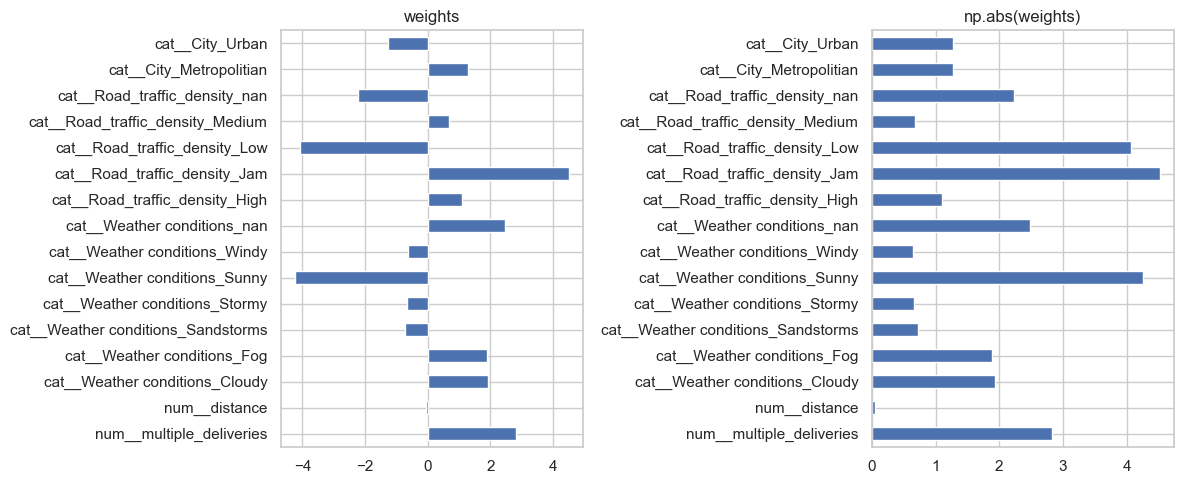

In [ ]:
def plot_importances(model, figsize=(12, 8), keep_zero=True):
    '''
    - model: Pipeline – входная линейная модель
    - figsize: Tuple[int, int] – размер изображения
    - keep_zero: bool – отрисовывать признаки с весами равными нулю
    '''
    # место для вашего кода


# можете менять аргумент figsize, чтобы график выглядел красиво

plot_importances(model, figsize=(12, 5))

### Обучаем модель \[итерация 2\] (1 балл)

Попробуйте добавить признаки, связанные со временем, когда был оформлен заказ. Еще раз посмотрите в EDA, подумайте, какие признаки могут быть полезными.

In [ ]:
# место для вашего кода

In [ ]:
score = mean_absolute_error(y_true, y_pred)

'В среднем мы ошибаемся на %.2f минут' % score

In [ ]:
score = mean_absolute_percentage_error(y_true, y_pred)

'В среднем мы ошибаемся на %.2f%%' % (100 * score)

In [ ]:
# можете менять аргумент figsize, чтобы график выглядел красиво

plot_importances(model, figsize=(12, 9))

### Обучаем модель \[итерация 3\] (1 балл)

Попробуйте добавить признаки, связанные c курьером. **Придумайте**, какие признаки можно добавить на основе `Delivery_person_ID`.

Попробуйте добавить возраст курьера двумя вариантами:
- Как числовой признак;
- Как категориальный признак (разбейте его на бакеты), см. `np.digitize`.

Как правильно выбирать бакеты для этой задачи? Какой из этих вариантов работает лучше?

**Не удаляйте** признаки с предыдущего этапа, если они улучшили качество модели.

In [ ]:
# место для вашего кода

In [ ]:
score = mean_absolute_error(y_true, y_pred)

'В среднем мы ошибаемся на %.2f минут' % score

In [ ]:
score = mean_absolute_percentage_error(y_true, y_pred)

'В среднем мы ошибаемся на %.2f%%' % (100 * score)

In [ ]:
# можете менять аргумент figsize, чтобы график выглядел красиво

plot_importances(model, figsize=(12, 12))

### Обучаем модель \[итерация 4\] (1 балл)

Полученная модель использует уже большое число признаков. Примените регуляризацию для уменьшения количества признаков в модели **без потери качества**.

In [ ]:
# место для вашего кода

In [ ]:
score = mean_absolute_error(y_true, y_pred)

'В среднем мы ошибаемся на %.2f минут' % score

In [ ]:
score = mean_absolute_percentage_error(y_true, y_pred)

'В среднем мы ошибаемся на %.2f%%' % (100 * score)

In [ ]:
# можете менять аргумент figsize, чтобы график выглядел красиво

plot_importances(model, figsize=(12, 8), keep_zero=False)

### Анализ остатков (1 балл)

Осталось проанализировать остатки лучшей модели. Постройте:
- Распределение остатков модели;
- График зависимости остатков от истинного предсказания.

Напишите выводы, которые вы сделали из полученных графиков. Предложите возможное решение, как улучшить проблему перепредсказаний и недопредсказаний.

In [ ]:
# место для вашего кода